## Get the data

In [1]:
import sqlalchemy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import qstools as qs
import qstools.indicators as qsi
import math

import warnings
warnings.simplefilter('ignore')

In [2]:
cids_dmca = ['AUD', 'CAD', 'CHF', 'EUR', 'GBP', 'JPY', 'NOK', 'NZD', 'SEK', 'USD']  # DM currency areas
cids_dmec = ['DEM', 'ESP', 'FRF', 'ITL', 'NLG']  # DM euro area countries
cids_latm = ['ARS', 'BRL', 'COP', 'CLP', 'MXN', 'PEN']  # Latam countries
cids_emea = ['HUF', 'ILS', 'PLN', 'RON', 'RUB', 'TRY', 'ZAR']  # EMEA countries
cids_emas = ['CNY', 'HKD', 'IDR', 'INR', 'KRW', 'MYR', 'PHP', 'SGD', 'THB', 'TWD']  # EM Asia countries
cids_dm = cids_dmca + cids_dmec
cids_em = cids_latm + cids_emea + cids_emas
cids = sorted(cids_dm + cids_em)

In [4]:
from_DB = True
path_to_feather = "..//..//data//feathers//"

base_cats = ['FXXR', 'FXCRY', 'FXCRR']
add_cats = ['_NSA', '_VT10', '_VT10vGLB29', 'HvGDRB_NSA', 'HvGDRBvGLB29_NSA']
xcats = [base + add for add in add_cats for base in base_cats] + ['FXXRxLEV10_NSA','FXXRxEASD_NSA', 'FXXRBETAvGDRB_NSA']

if from_DB:
    dbi = qsi.DownloadQuantamentalIndicators(username="rsueppel",
                                             host="qs-db.cpdsgdta9z0z.eu-west-2.rds.amazonaws.com",
                                             password="l3oT7^WerjY#O!9EGqvL",
                                             database="qs_jpm_point_time")
    dfd = dbi.get_xcat(cross_section = cids, xcat = xcats).reset_index(drop=True)
    dfd.to_feather(f'{path_to_feather}dfd_fxcr_qmtl.ftr')   
else:
    dfd = pd.read_feather(f'{path_to_feather}dfd_fxcr_qmtl.ftr')

In [5]:
dfd[['cross_section', 'xcat']] = dfd['ticker'].str.split('_', 1, expand=True)
dfd['real_date'] = pd.to_datetime(dfd['real_date'])

In [6]:
dfd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2969484 entries, 0 to 2969483
Data columns (total 8 columns):
 #   Column         Dtype         
---  ------         -----         
 0   ticker         object        
 1   real_date      datetime64[ns]
 2   value          float64       
 3   grading        object        
 4   eop_lag        int64         
 5   mop_lag        int64         
 6   cross_section  object        
 7   xcat           object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 181.2+ MB


In [7]:
cids_exp = sorted(list(set(cids) - set(cids_dmec + ['ARS', 'HKD', 'USD'])))  # expected cids
xcats_exp = xcats  # expected xcats, in most cases equal to xcats

print('Missing xcats across df: ', set(xcats_exp) - set(dfd['xcat'].unique()))  # any xcats missing
xcats_used = sorted(list(set(xcats_exp).intersection(set(dfd['xcat'].unique()))))
for xcat in xcats_used:
    cids_xcat = dfd.loc[dfd['xcat']==xcat, 'cross_section'].unique()
    print(f'Missing cids for {xcat}: ', set(cids_exp) - set(cids_xcat))  # any cross section missing?

Missing xcats across df:  set()
Missing cids for FXCRRHvGDRB_NSA:  set()
Missing cids for FXCRRHvGDRBvGLB29_NSA:  {'CNY', 'EUR'}
Missing cids for FXCRR_NSA:  set()
Missing cids for FXCRR_VT10:  set()
Missing cids for FXCRR_VT10vGLB29:  {'CNY', 'EUR'}
Missing cids for FXCRYHvGDRB_NSA:  set()
Missing cids for FXCRYHvGDRBvGLB29_NSA:  {'CNY', 'EUR'}
Missing cids for FXCRY_NSA:  set()
Missing cids for FXCRY_VT10:  set()
Missing cids for FXCRY_VT10vGLB29:  {'CNY', 'EUR'}
Missing cids for FXXRBETAvGDRB_NSA:  set()
Missing cids for FXXRHvGDRB_NSA:  set()
Missing cids for FXXRHvGDRBvGLB29_NSA:  {'CNY', 'EUR'}
Missing cids for FXXR_NSA:  set()
Missing cids for FXXR_VT10:  set()
Missing cids for FXXR_VT10vGLB29:  {'CNY', 'EUR'}
Missing cids for FXXRxEASD_NSA:  set()
Missing cids for FXXRxLEV10_NSA:  set()


## Functions

In [8]:
def check_availability(df, xcats, cids=None, size=None):
    """Display starting years across extended categories and cross sections"""
    
    dfx = df[df['xcat'].isin(xcats)]
        
    cids_in_df = dfx['cross_section'].unique()
    if cids is None:
        cids = sorted(cids_in_df)
    else:
        print(f'Missing cross sections: ', set(cids) - set(cids_in_df))
        cids = sorted(list(set(cids).intersection(set(cids_in_df))))
        dfx = dfx[dfx['cross_section'].isin(cids)]
    
    df_rstarts = dfx[['cross_section', 'xcat', 'real_date']].groupby(['cross_section', 'xcat']).min()
    df_rstarts['real_date']=pd.DatetimeIndex(df_rstarts.loc[:,'real_date']).year
    df_rstarts = df_rstarts.unstack().loc[:,'real_date']
    
    if size is None:
        size = (max(len(cids)/2, 15), max(1, len(xcats)/2))
    fig, ax = plt.subplots(figsize=size)
    sns.heatmap(df_rstarts.T, cmap='Reds', center=2002, annot=True, fmt='.0f', linewidth=1, cbar=False)
    plt.xlabel('')
    plt.ylabel('')
    plt.show()

In [9]:
def bars_sds(df, xcats, start_year=2000, cids=None, val=None, title=None, ylab=None):
    """Plot level bars and SD ranges across extended categories and cross sections"""
    
    filt1 = df['real_date'].dt.year >= start_year
    filt2 = df['xcat'].isin(xcats)
    
    dfx = dfd[filt1 & filt2]
    
    cids_in_df = dfx['cross_section'].unique()
    if cids is None:
        cids = sorted(cids_in_df)
    else:
        print(f'Missing cross sections: ', set(cids) - set(cids_in_df))
        cids = sorted(list(set(cids).intersection(set(cids_in_df))))
        dfx = dfx[dfx['cross_section'].isin(cids)]
    
    sns.set(style="whitegrid")
    
    if val is None:
        val = 'value'
    if title is None:
        title = f'Means and standard deviations since {start_year}'
    if ylab is None:
        ylab=""

    g = sns.catplot(
        data=dfx, kind="bar", height=6, aspect=2.5,
        x="cross_section", y=val, hue="xcat",
        ci="sd", palette="Paired", alpha=.6, order = cids
    )
    g.despine(left=True)
    g.axes[0][0].axhline(y=0, xmin=0, xmax=1, color='grey', linewidth=1)
    g.fig.suptitle(title, y = 1.03, fontsize=14)
    g.set_axis_labels("", ylab)
    plt.show()

In [31]:
def timeline_grid(df, xcats, start_year=2000, cids=None, val='value', ncol=3, same_y=False, cumsum=False):
    """Plot grid of timelines of one or more extended categories across sections"""
    
    filt1 = df['real_date'].dt.year >= start_year
    filt2 = df['xcat'].isin(xcats)
    
    dfx = df[filt1 & filt2]
    
    cids_in_df = dfx['cross_section'].unique()
    if cids is None:
        cids = sorted(cids_in_df)
    else:
        print(f'Missing cross sections: ', set(cids) - set(cids_in_df))
        cids = sorted(list(set(cids).intersection(set(cids_in_df))))
        dfx = dfx[dfx['cross_section'].isin(cids)]
    
    if cumsum:
        dfx['value'] = dfx[['cross_section', 'xcat', 'value']].groupby(['cross_section', 'xcat']).cumsum()

    sns.set(rc={'figure.figsize':(12, 7)}, style = 'whitegrid')
    fg = sns.FacetGrid(dfx, col='cross_section', col_wrap = ncol, sharey=same_y, aspect = 1.7, col_order = cids)
    fg.map_dataframe(sns.lineplot, x='real_date', y=val, hue='xcat', ci=None)
    fg.map(plt.axhline, y=0, c=".5")
    fg.set_titles(col_template='{col_name}')
    fg.add_legend()
    plt.show()

In [11]:
def map_xcorrel(df, xcat, cids, start):
    
    df = df[df['xcat']==xcat]

    cids_in_df = df['cross_section'].unique()
    if cids is None:
        cids = sorted(cids_in_df)
    else:
        print(f'Missing cross sections: ', set(cids) - set(cids_in_df))
        cids = sorted(list(set(cids).intersection(set(cids_in_df))))
        df = df[df['cross_section'].isin(cids)]

    df_w = df.pivot(index='real_date', columns='cross_section', values='value')

    sns.set(style="ticks")  
    corr = df_w.corr()  # compute correlation matrix
    mask = np.triu(np.ones_like(corr, dtype=bool))  # generate mask for upper triangle
    f, ax = plt.subplots(figsize=(14, 8))  # set up figure
    sns.heatmap(corr, mask=mask, cmap='vlag_r', vmin = -0.2, center=0,
                square=False, linewidths=.5, cbar_kws={"shrink": .5})
    ax.set(xlabel='', ylabel='')
    ax.set_title(f'Cross crorrelation of {xcat} since {start}',fontsize=14)
    plt.show()

## Availability

Missing cross sections:  set()


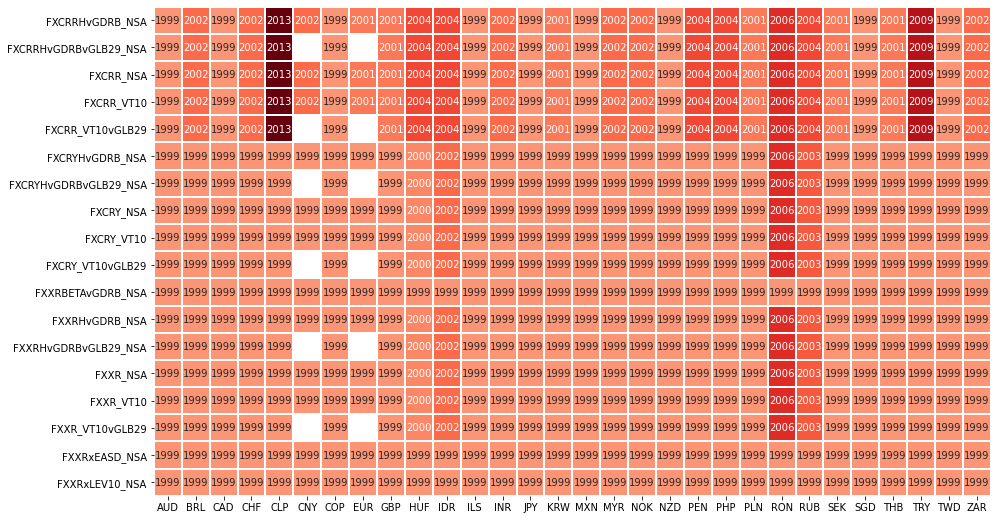

In [12]:
check_availability(dfd, xcats=xcats, cids=cids_exp)

## Distributions and timelines

### Vol, leverage and beta

#### Volatility

Missing cross sections:  set()


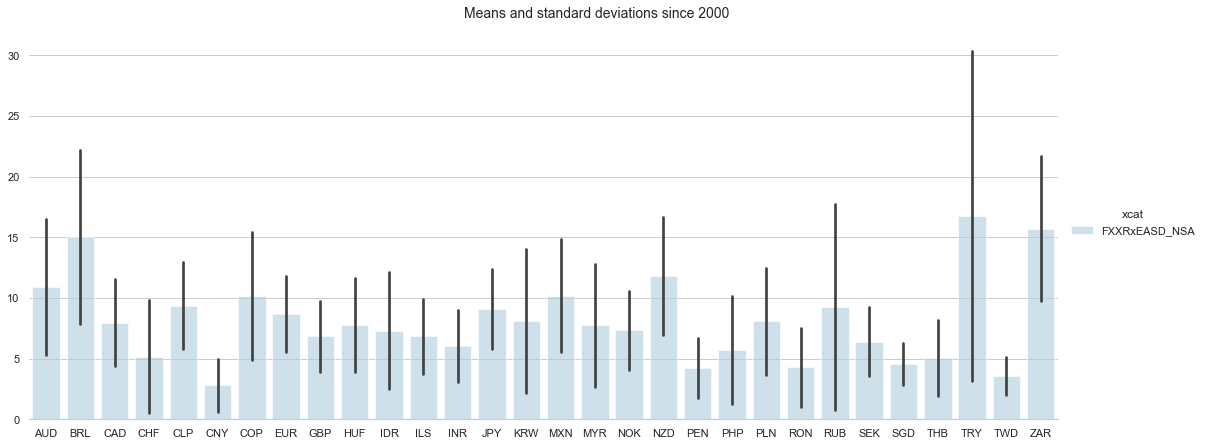

In [14]:
bars_sds(dfd, xcats=['FXXRxEASD_NSA'], cids=cids_exp)

Missing cross sections:  {'FRF', 'DEM', 'ITL', 'ESP', 'USD', 'NLG'}


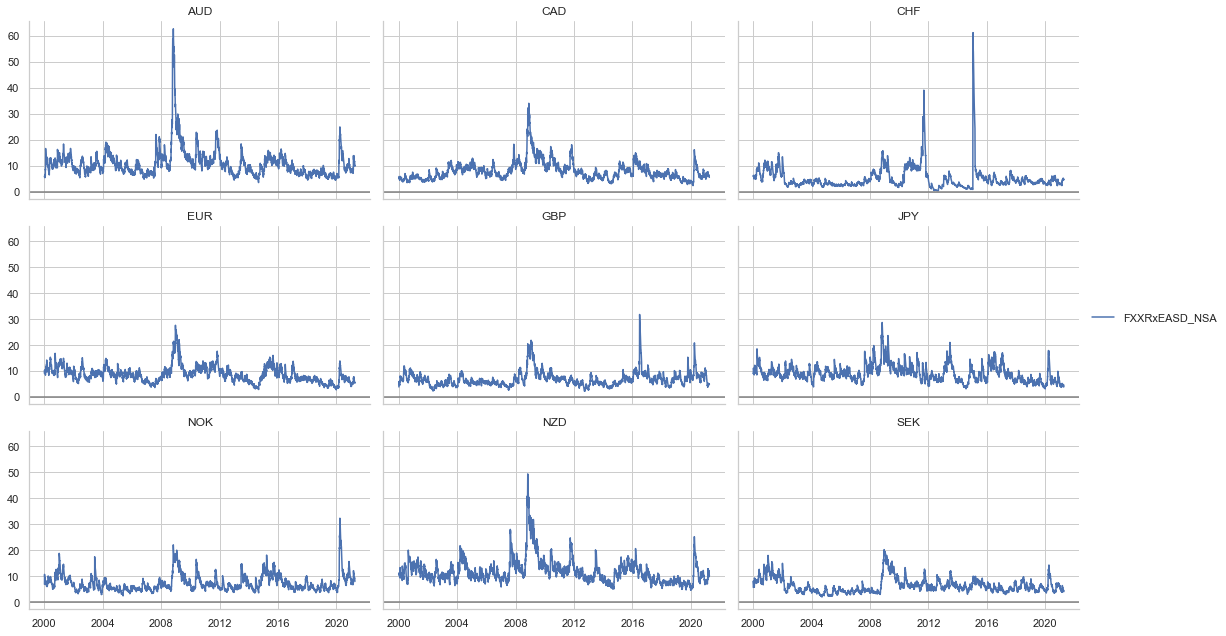

In [16]:
timeline_grid(dfd, xcats=['FXXRxEASD_NSA'], cids=cids_dm, same_y=True)

Missing cross sections:  {'ARS', 'HKD'}


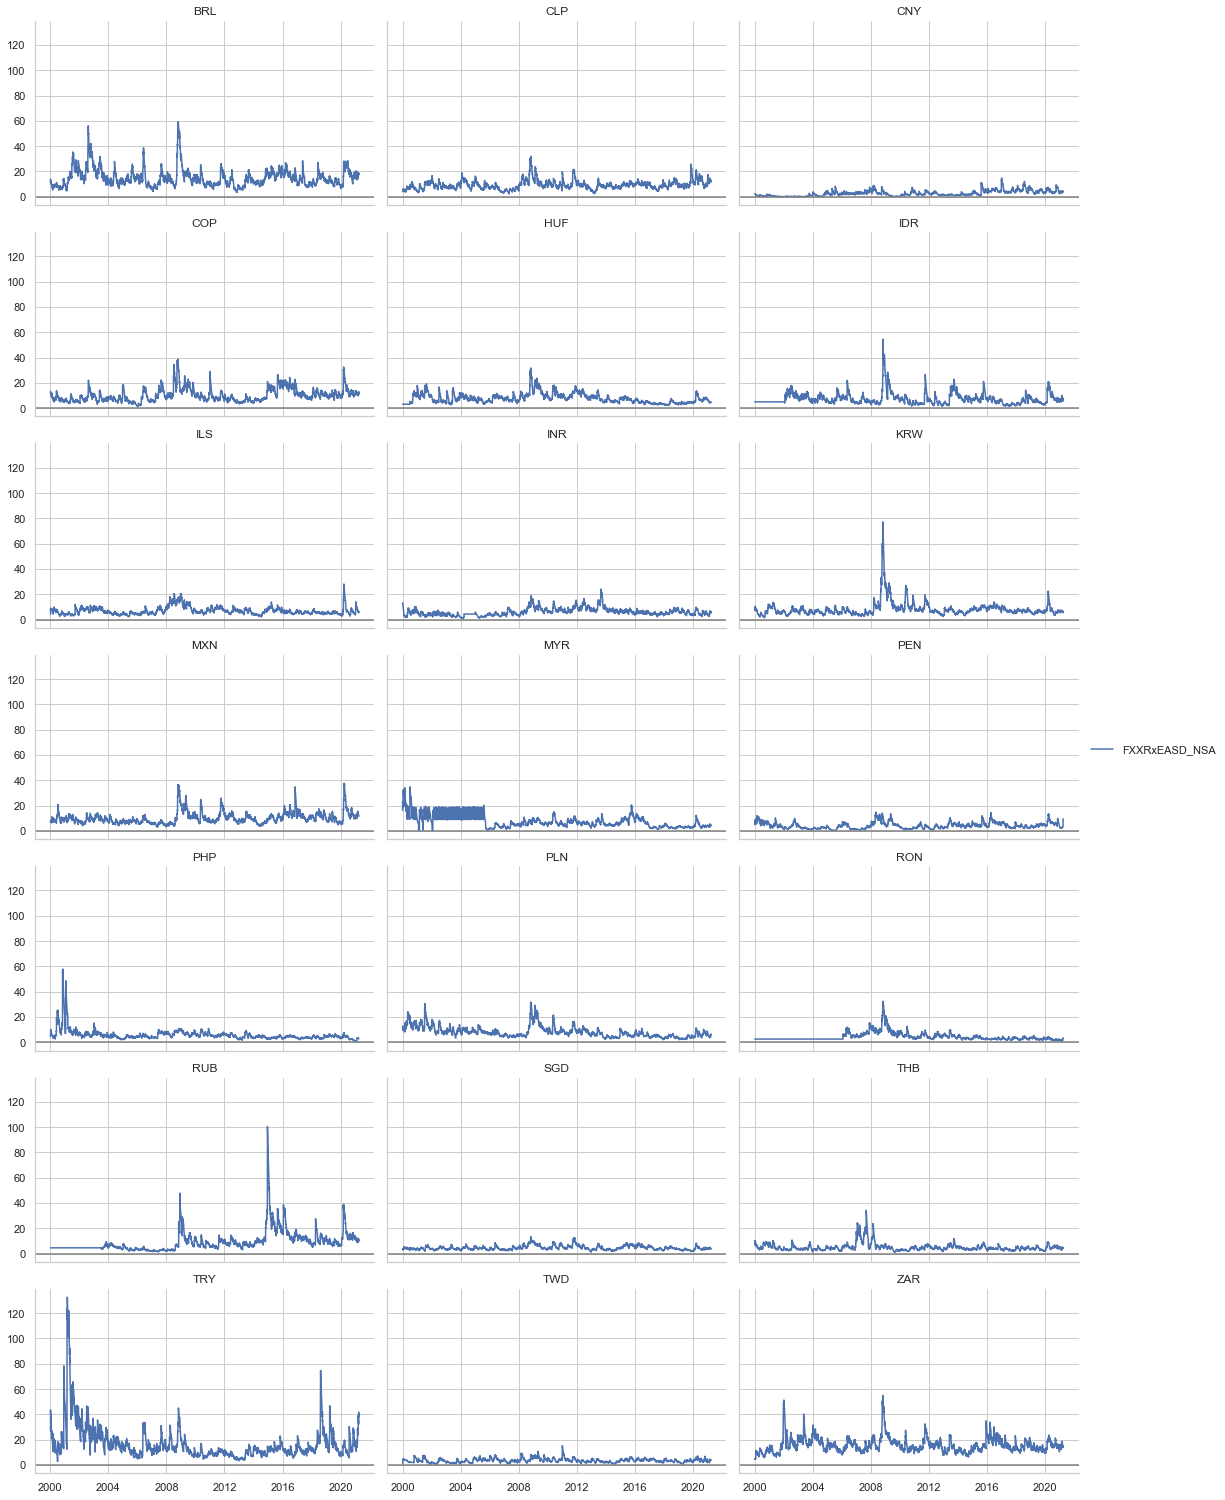

In [17]:
timeline_grid(dfd, xcats=['FXXRxEASD_NSA'], cids=cids_em, same_y=True)

#### Leverage

Missing cross sections:  set()


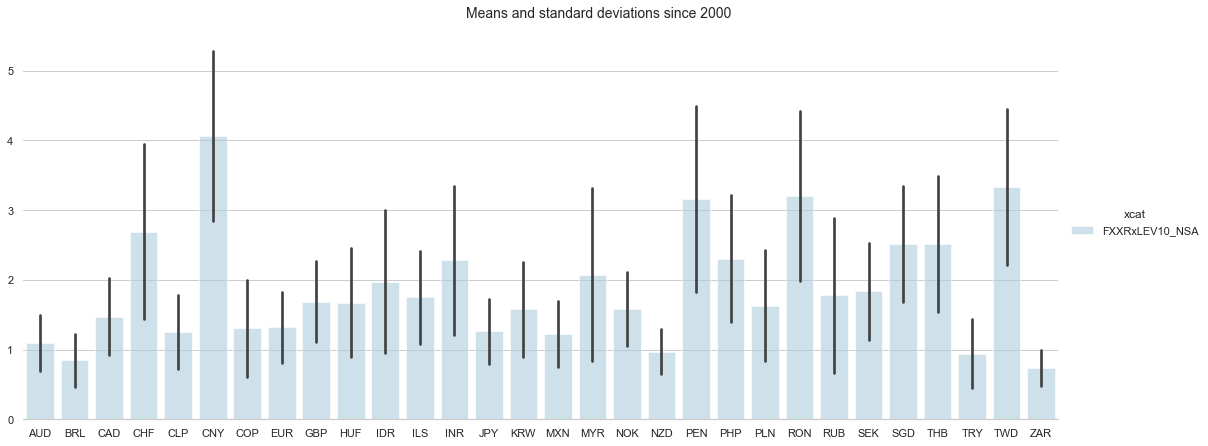

In [18]:
bars_sds(dfd, xcats=['FXXRxLEV10_NSA'], cids=cids_exp)

Missing cross sections:  {'FRF', 'DEM', 'ITL', 'ESP', 'USD', 'NLG'}


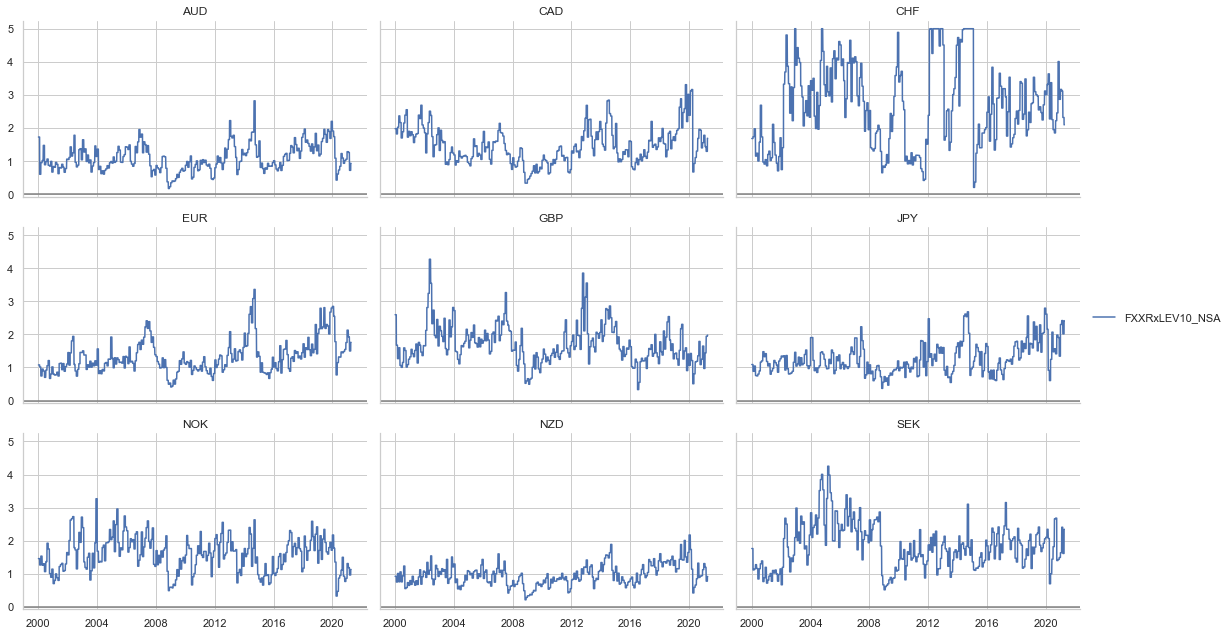

In [19]:
timeline_grid(dfd, xcats=['FXXRxLEV10_NSA'], cids=cids_dm, same_y=True)

Missing cross sections:  {'ARS', 'HKD'}


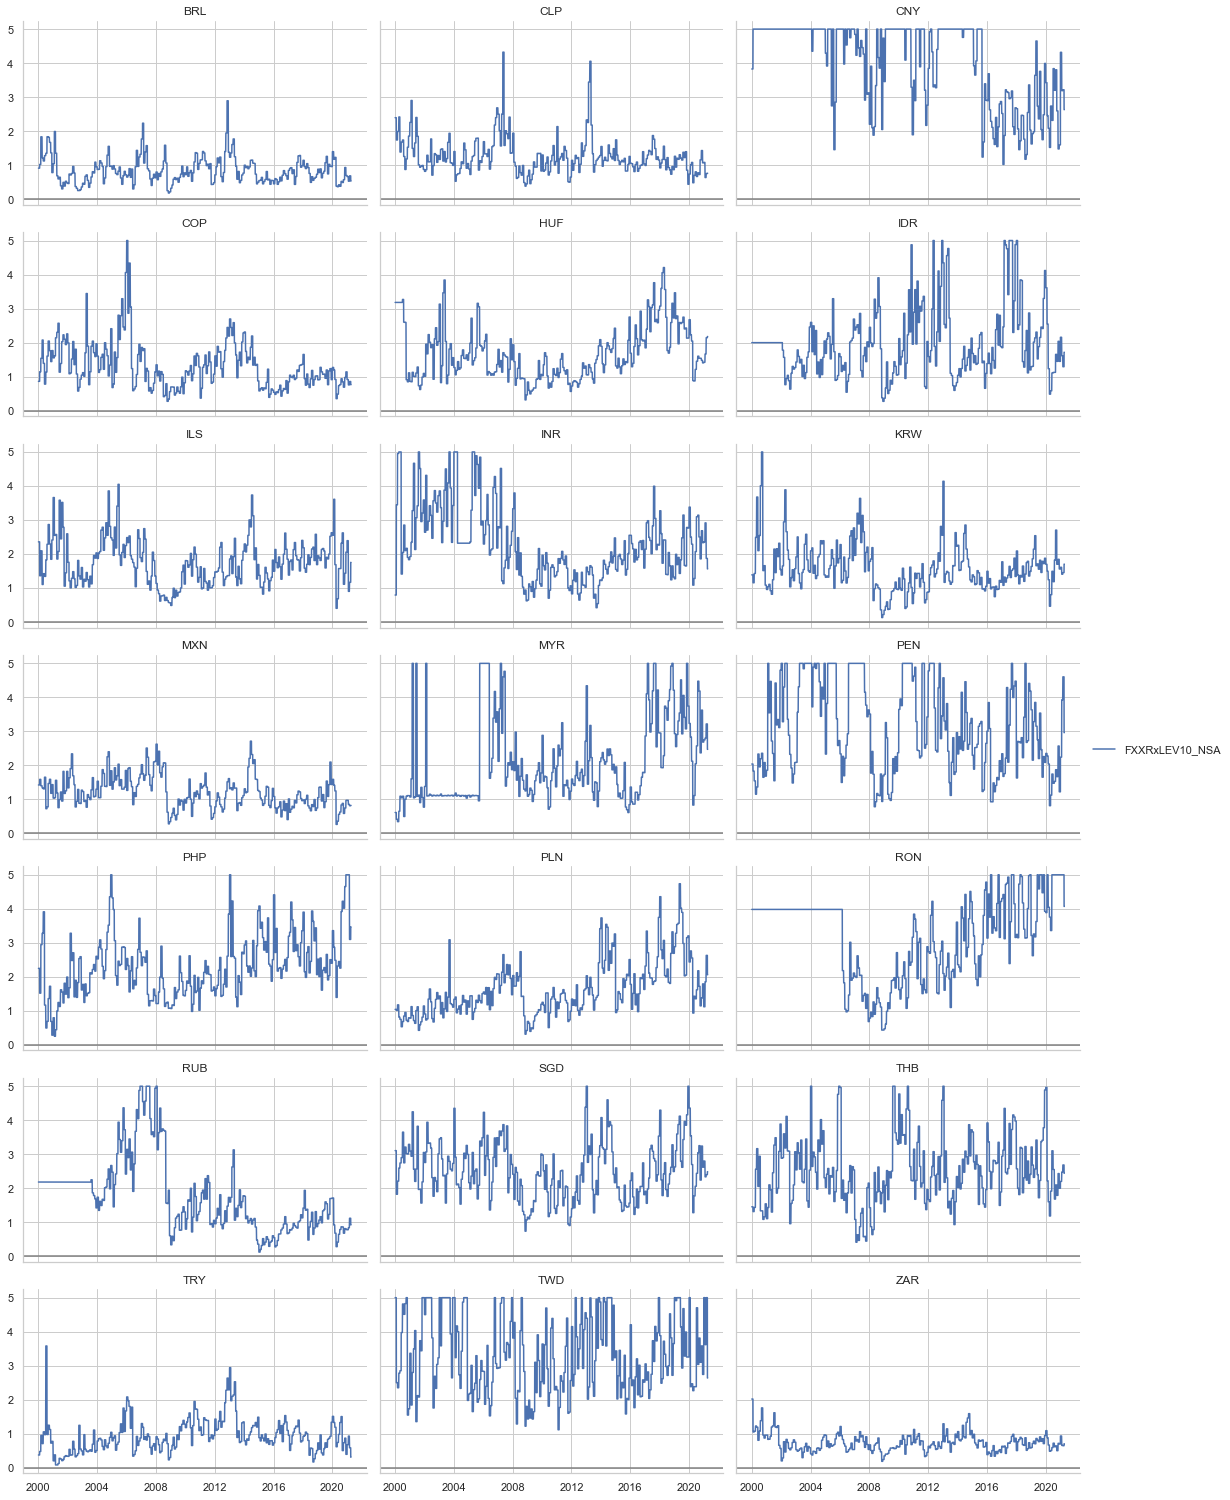

In [20]:
timeline_grid(dfd, xcats=['FXXRxLEV10_NSA'], cids=cids_em, same_y=True)

#### GDRB beta

Missing cross sections:  set()


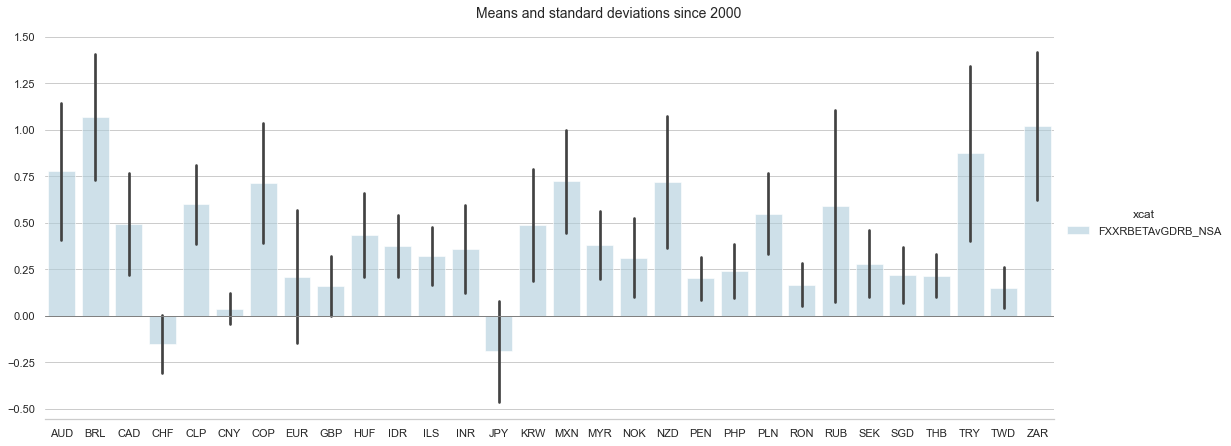

In [21]:
bars_sds(dfd, xcats=['FXXRBETAvGDRB_NSA'], cids=cids_exp)

Missing cross sections:  {'FRF', 'DEM', 'ITL', 'ESP', 'USD', 'NLG'}


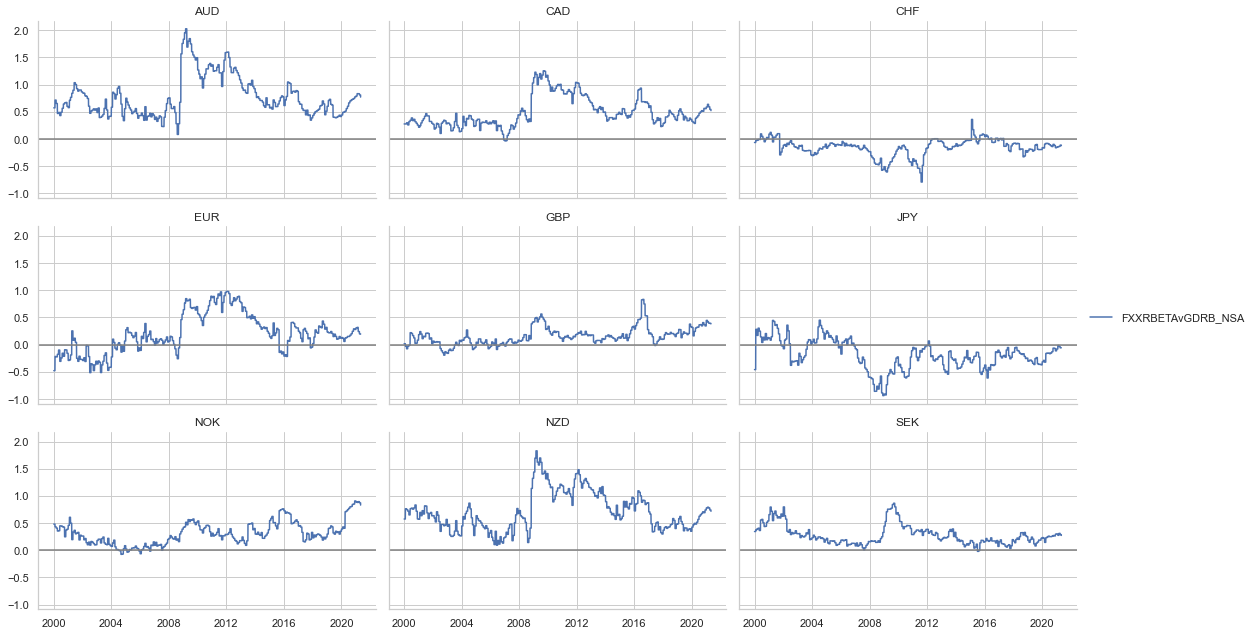

In [22]:
timeline_grid(dfd, xcats=['FXXRBETAvGDRB_NSA'], cids=cids_dm, same_y=True)

Missing cross sections:  {'ARS', 'HKD'}


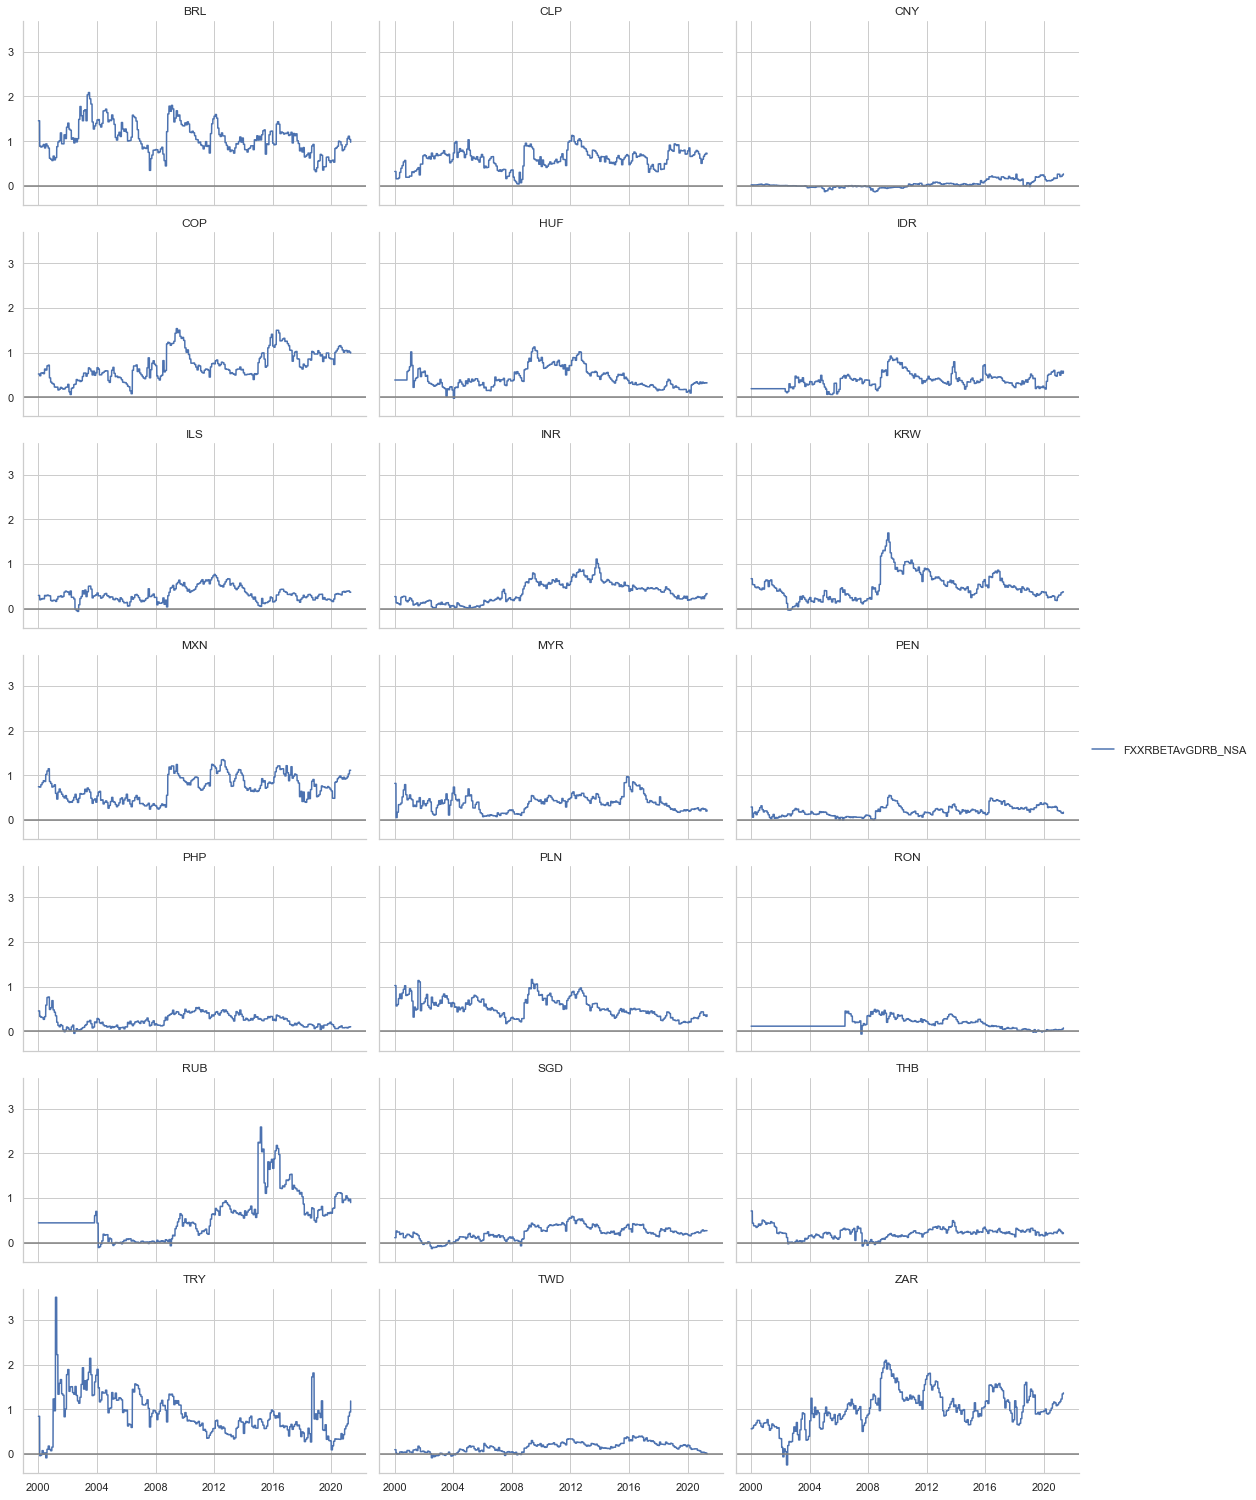

In [23]:
timeline_grid(dfd, xcats=['FXXRBETAvGDRB_NSA'], cids=cids_em, same_y=True)

### Returns

#### Unlevered returns

Missing cross sections:  set()


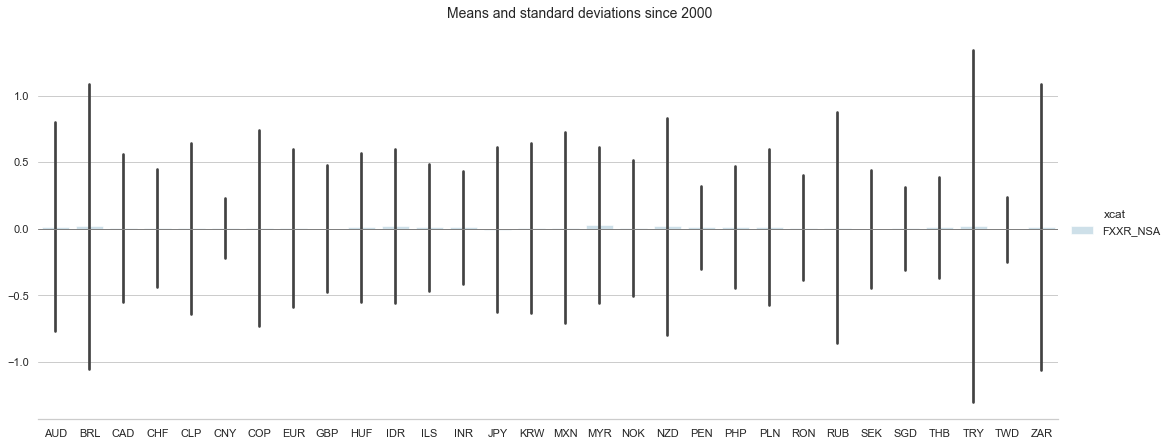

In [24]:
bars_sds(dfd, xcats=['FXXR_NSA'], cids=cids_exp)

Missing cross sections:  {'FRF', 'DEM', 'ITL', 'ESP', 'USD', 'NLG'}


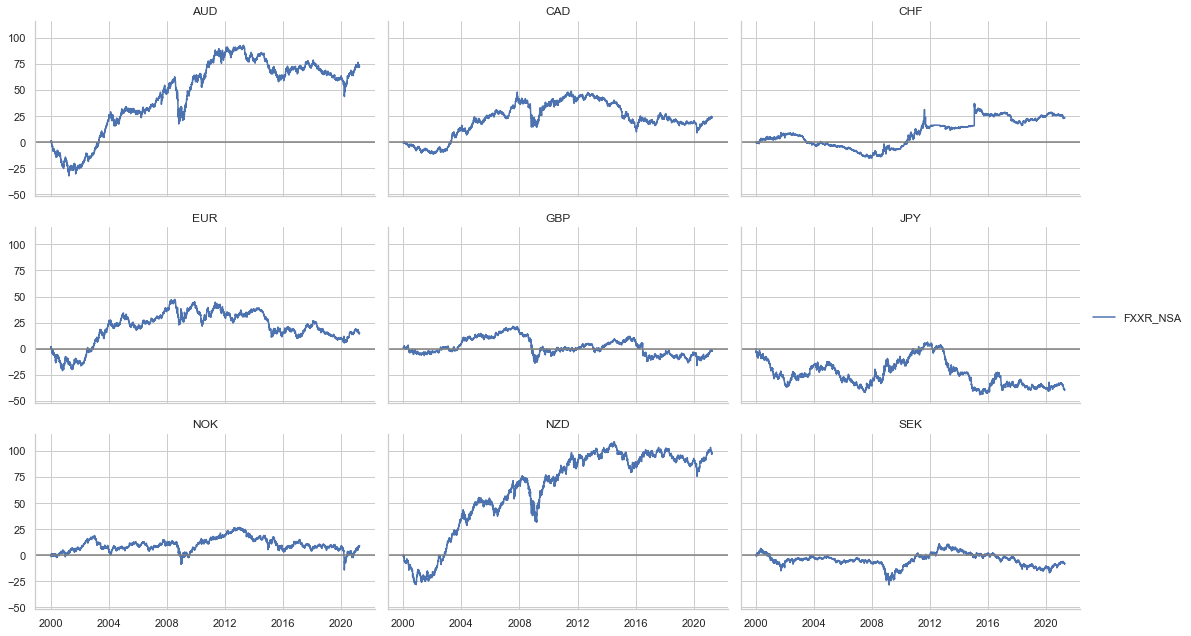

In [32]:
timeline_grid(dfd, xcats=['FXXR_NSA'], cids=cids_dm, same_y=True, cumsum=True)

Missing cross sections:  {'FRF', 'DEM', 'ITL', 'ESP', 'USD', 'NLG'}


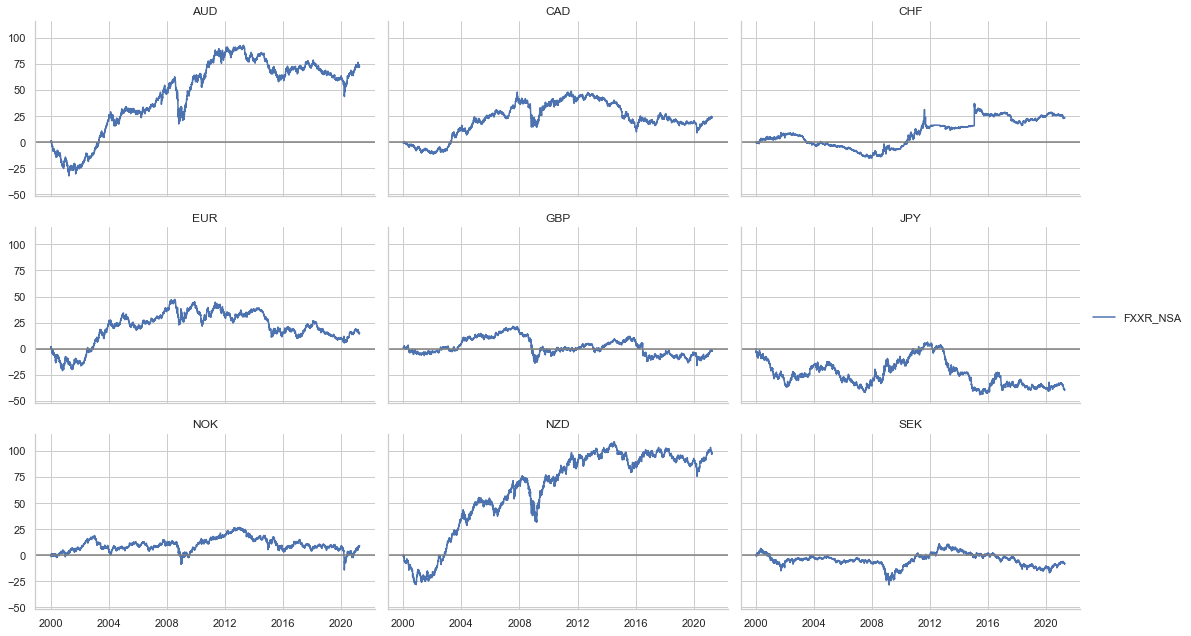

In [33]:
timeline_grid(dfd, xcats=['FXXR_NSA'], cids=cids_dm, same_y=True, cumsum=True)

#### Vol-targeted returns

Missing cross sections:  set()


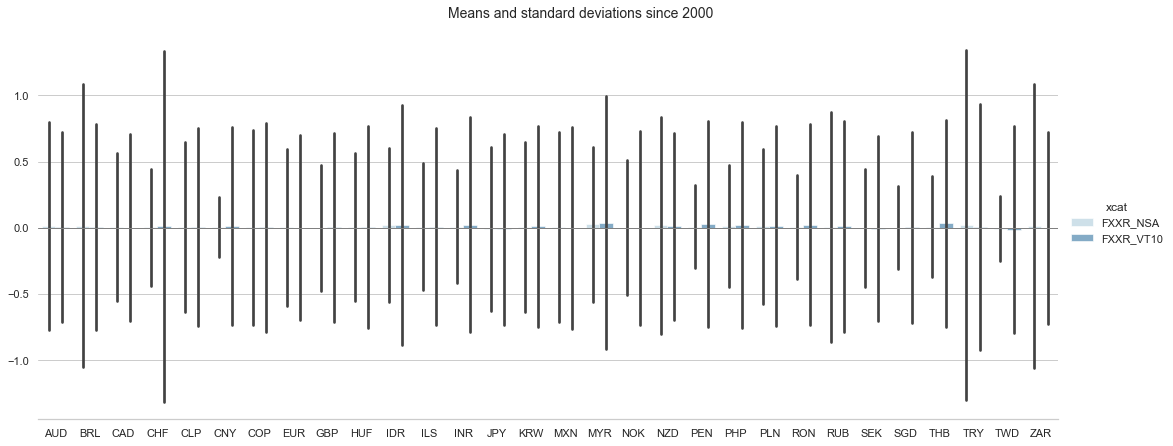

In [34]:
bars_sds(dfd, xcats=['FXXR_NSA', 'FXXR_VT10'], cids=cids_exp)

Missing cross sections:  {'FRF', 'DEM', 'ITL', 'ESP', 'USD', 'NLG'}


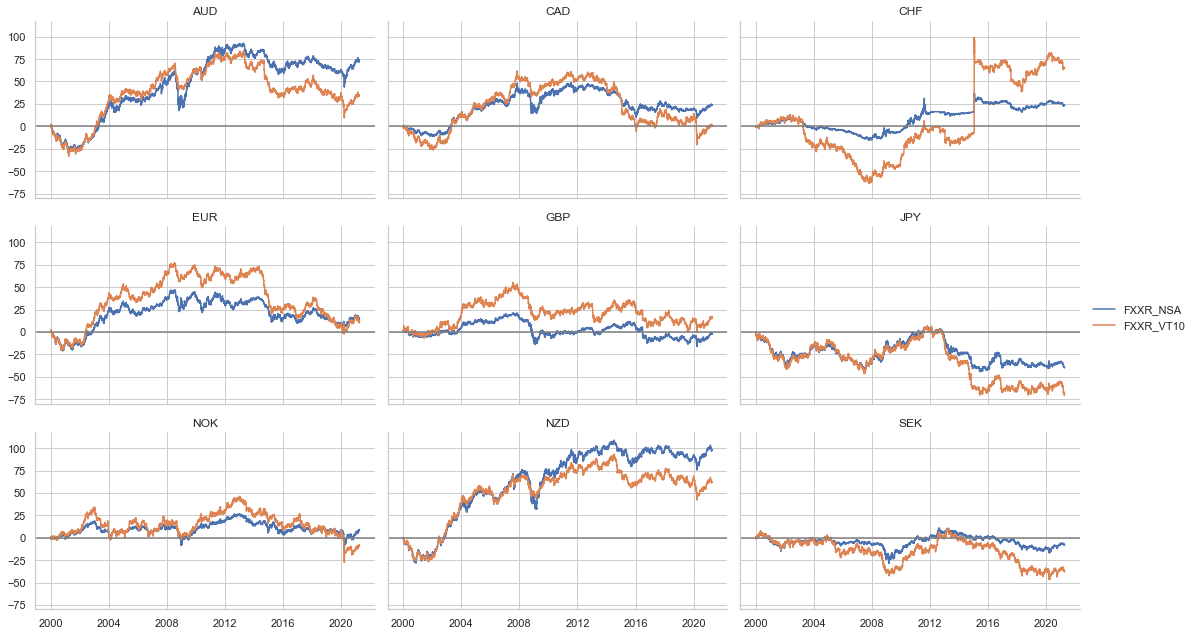

In [35]:
timeline_grid(dfd, xcats=['FXXR_NSA', 'FXXR_VT10'], cids=cids_dm, same_y=True, cumsum=True)

Missing cross sections:  {'ARS', 'HKD'}


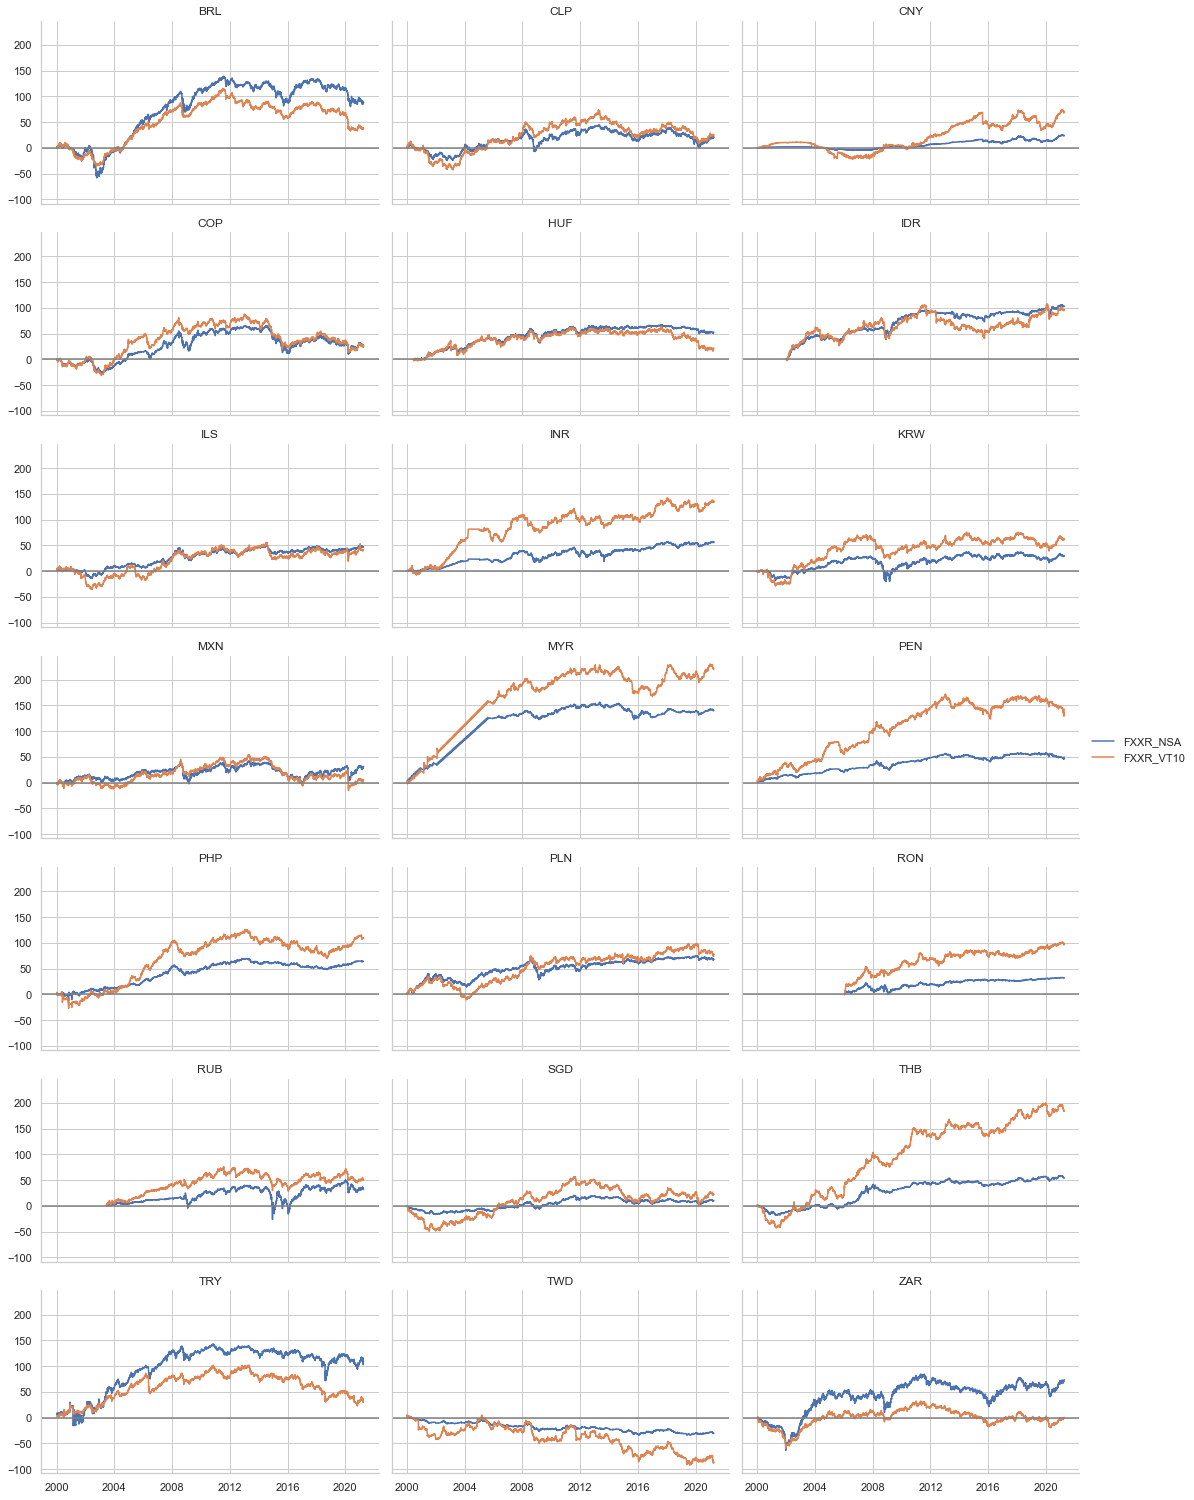

In [36]:
timeline_grid(dfd, xcats=['FXXR_NSA', 'FXXR_VT10'], cids=cids_em, same_y=True, cumsum=True)

#### Relative vol-targeted returns

Missing cross sections:  set()


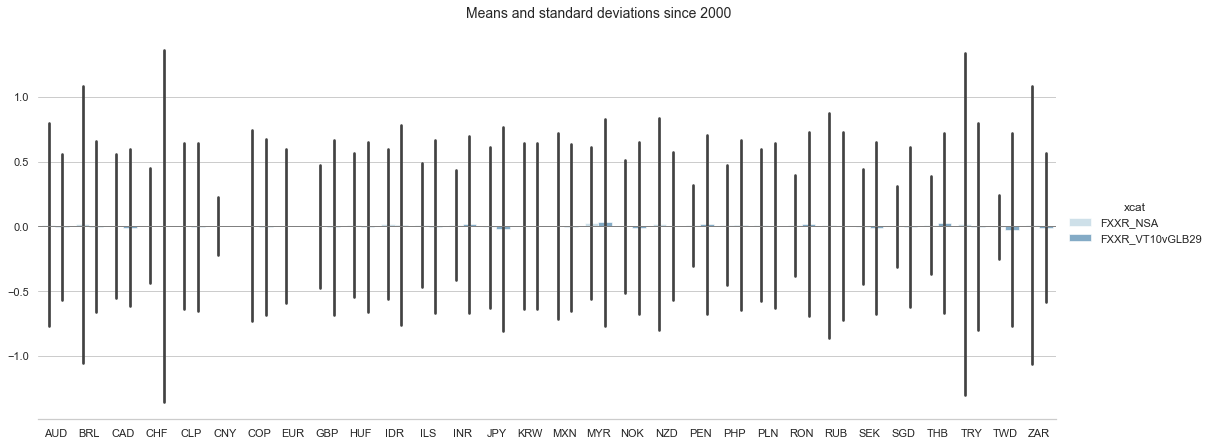

In [37]:
bars_sds(dfd, xcats=['FXXR_NSA', 'FXXR_VT10vGLB29'], cids=cids_exp)

Missing cross sections:  {'FRF', 'DEM', 'ITL', 'ESP', 'USD', 'NLG'}


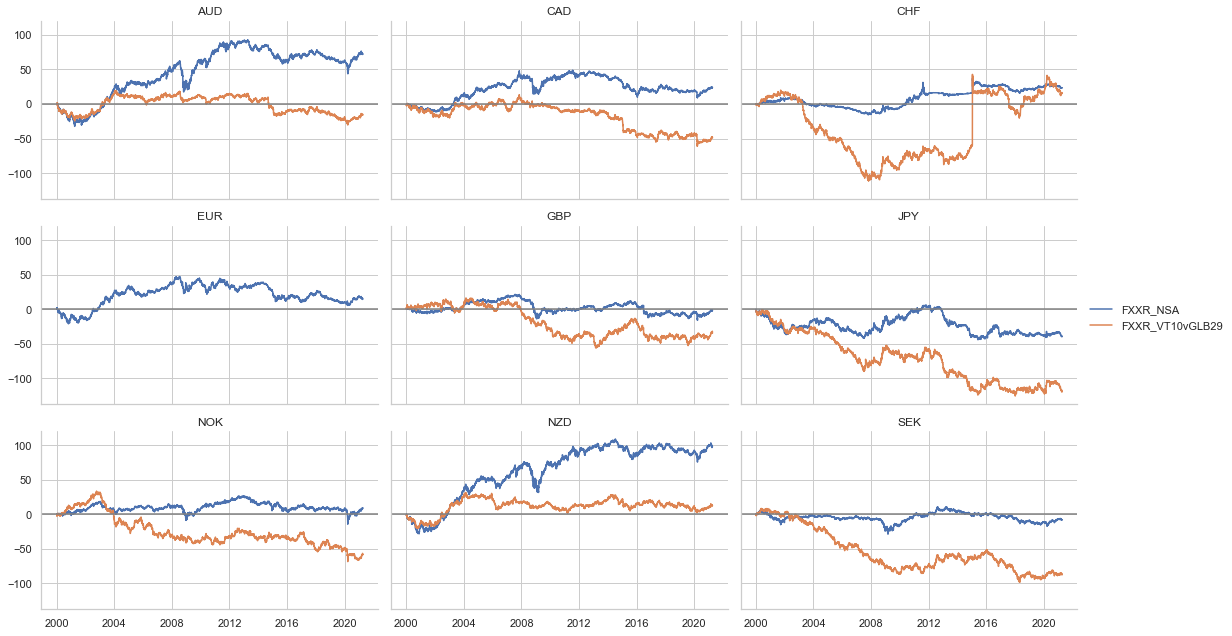

In [38]:
timeline_grid(dfd, xcats=['FXXR_NSA', 'FXXR_VT10vGLB29'], cids=cids_dm, same_y=True, cumsum=True)

Missing cross sections:  {'ARS', 'HKD'}


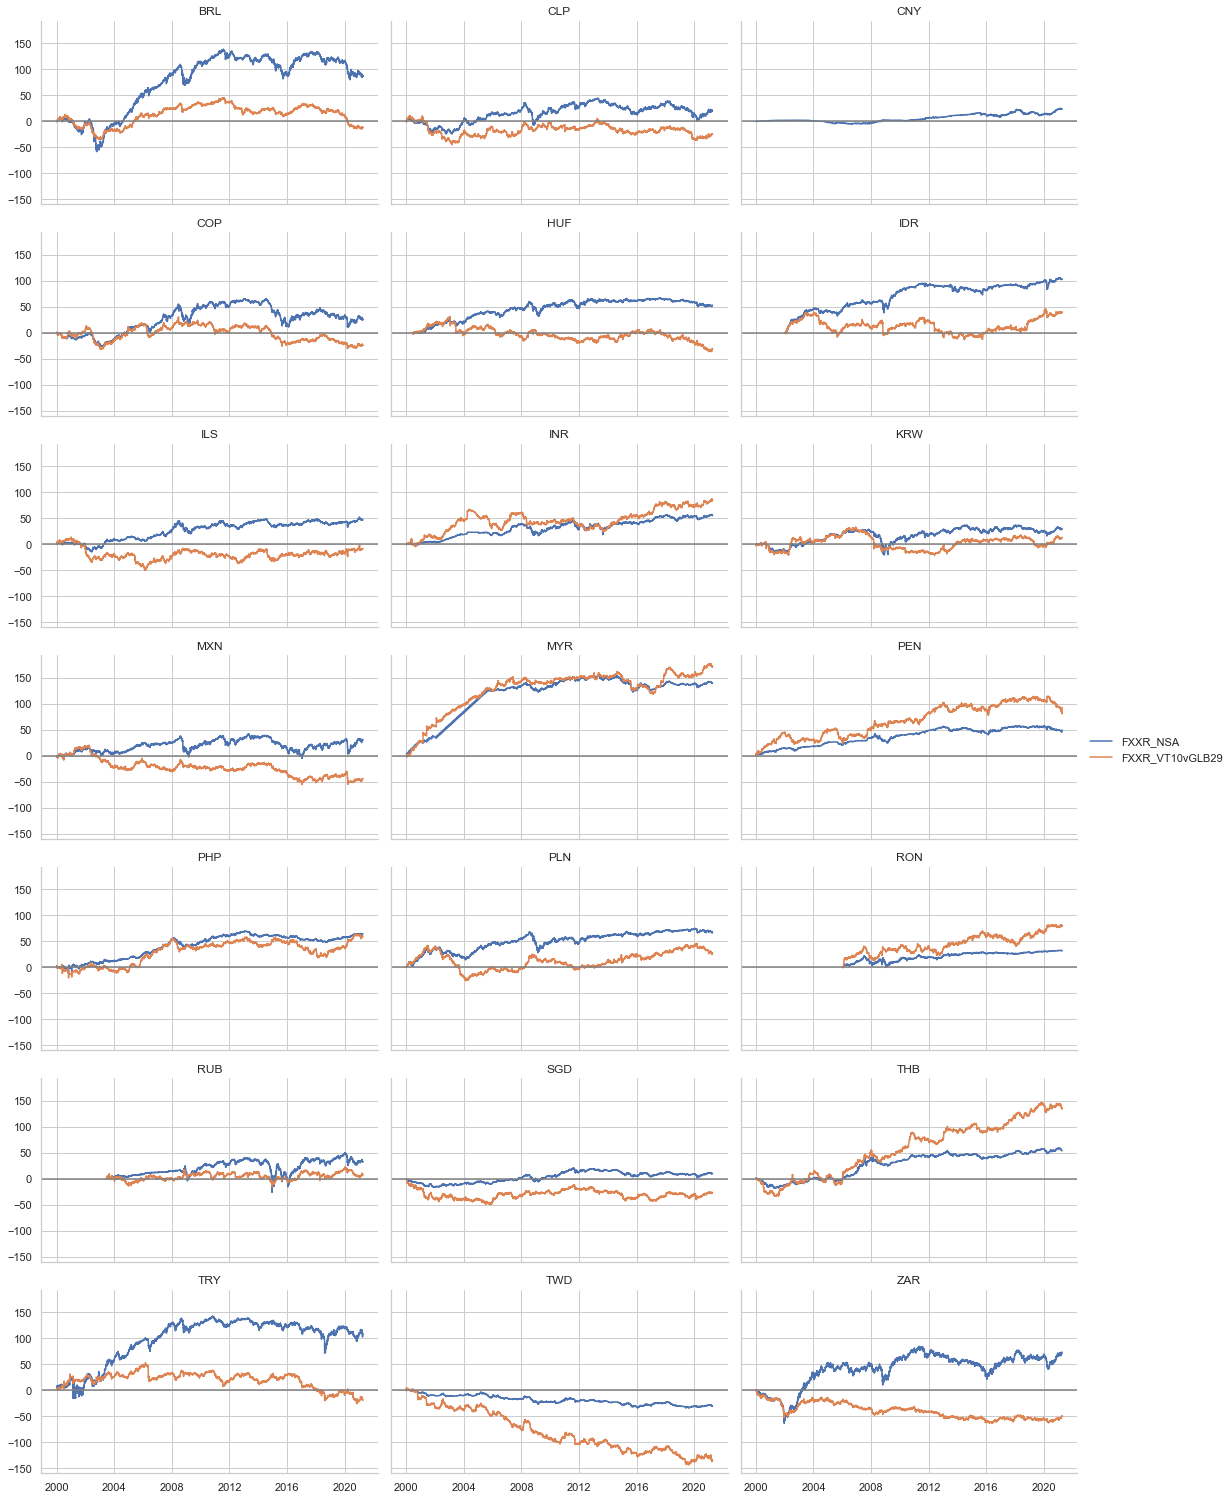

In [39]:
timeline_grid(dfd, xcats=['FXXR_NSA', 'FXXR_VT10vGLB29'], cids=cids_em, same_y=True, cumsum=True)

#### Hedged returns

Missing cross sections:  set()


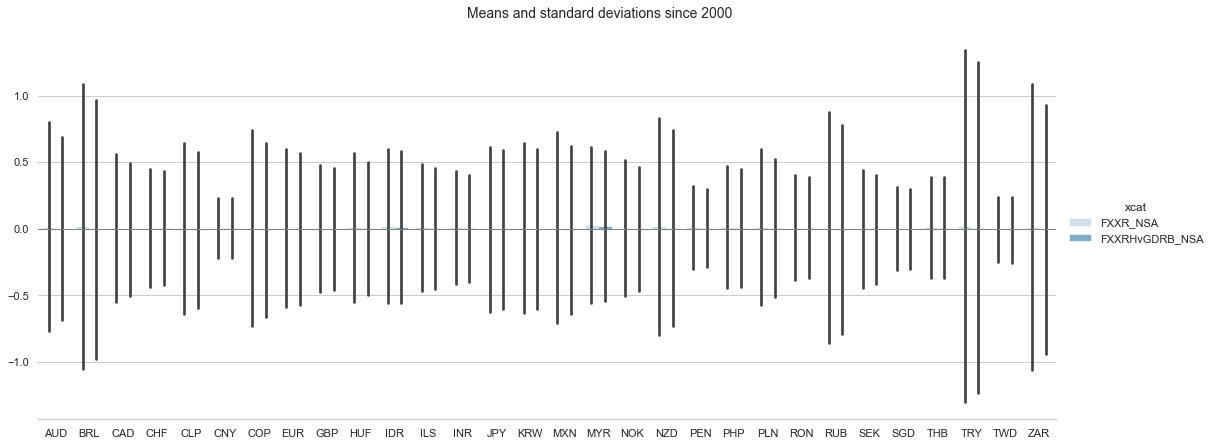

In [40]:
bars_sds(dfd, xcats=['FXXR_NSA', 'FXXRHvGDRB_NSA'], cids=cids_exp)

Missing cross sections:  {'FRF', 'DEM', 'ITL', 'ESP', 'USD', 'NLG'}


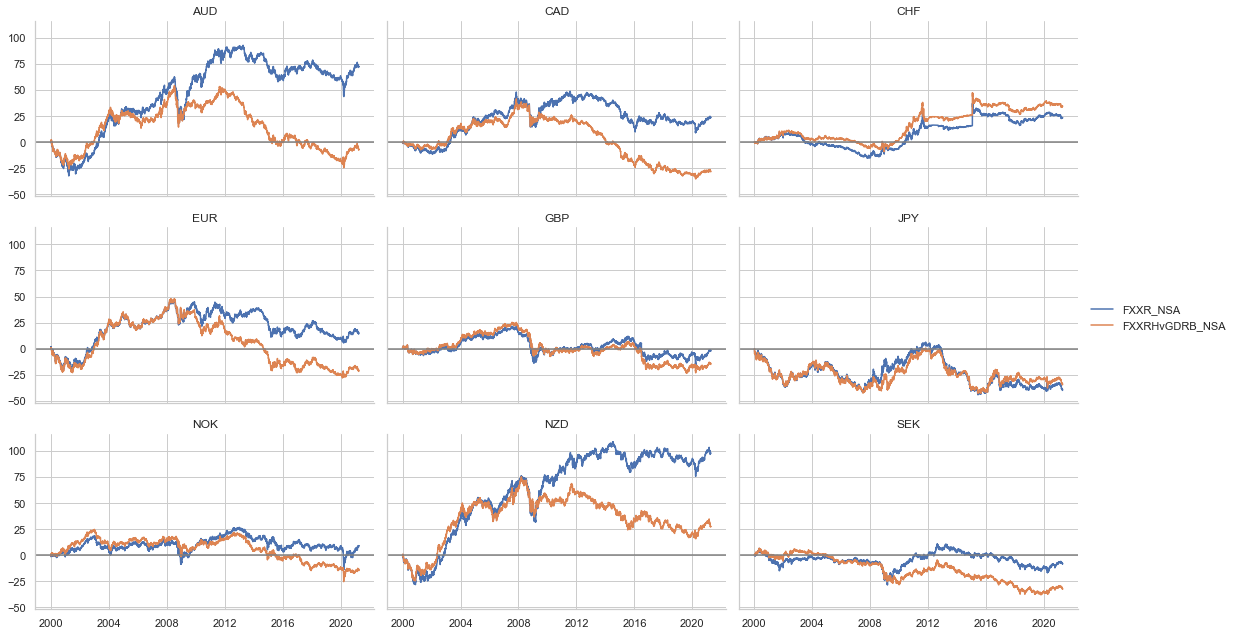

In [41]:
timeline_grid(dfd, xcats=['FXXR_NSA', 'FXXRHvGDRB_NSA'], cids=cids_dm, same_y=True, cumsum=True)

Missing cross sections:  {'ARS', 'HKD'}


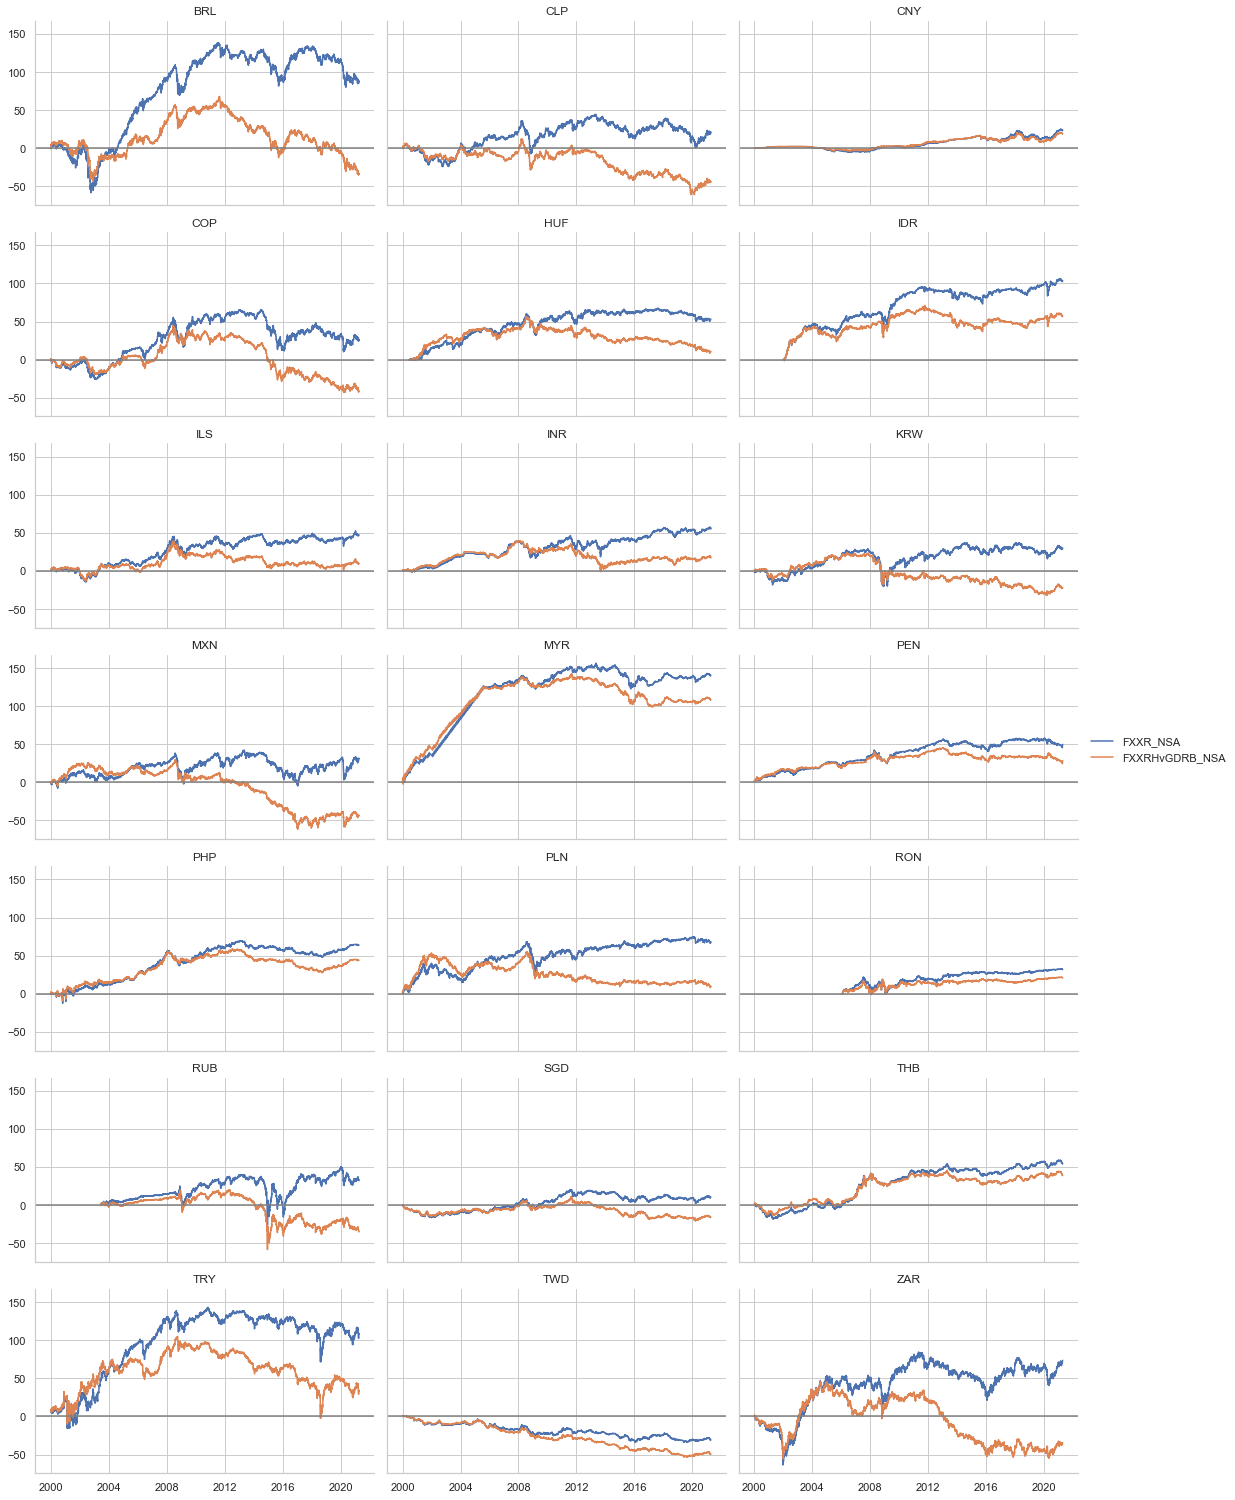

In [42]:
timeline_grid(dfd, xcats=['FXXR_NSA', 'FXXRHvGDRB_NSA'], cids=cids_em, same_y=True, cumsum=True)

#### Relative hedged returns

Missing cross sections:  set()


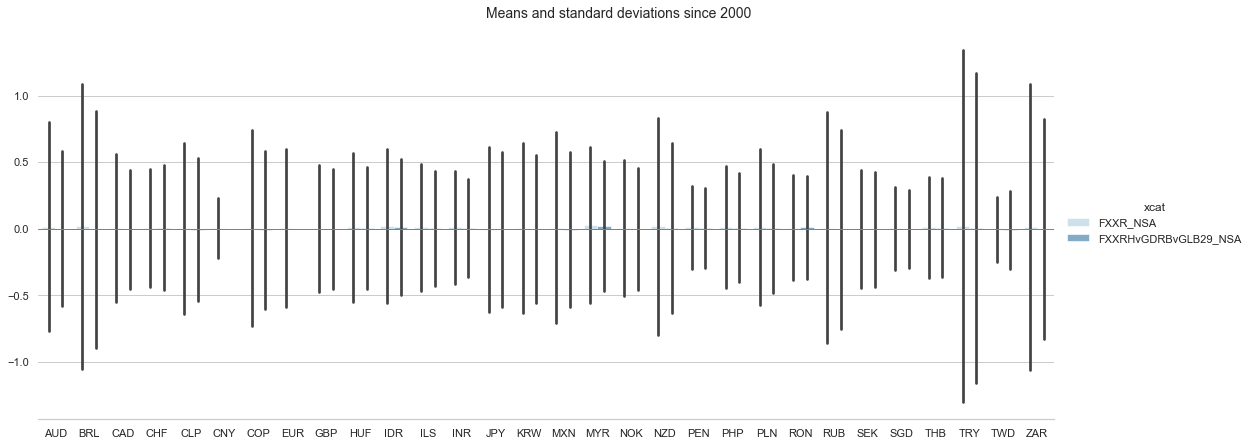

In [43]:
bars_sds(dfd, xcats=['FXXR_NSA', 'FXXRHvGDRBvGLB29_NSA'], cids=cids_exp)

Missing cross sections:  {'FRF', 'DEM', 'ITL', 'ESP', 'USD', 'NLG'}


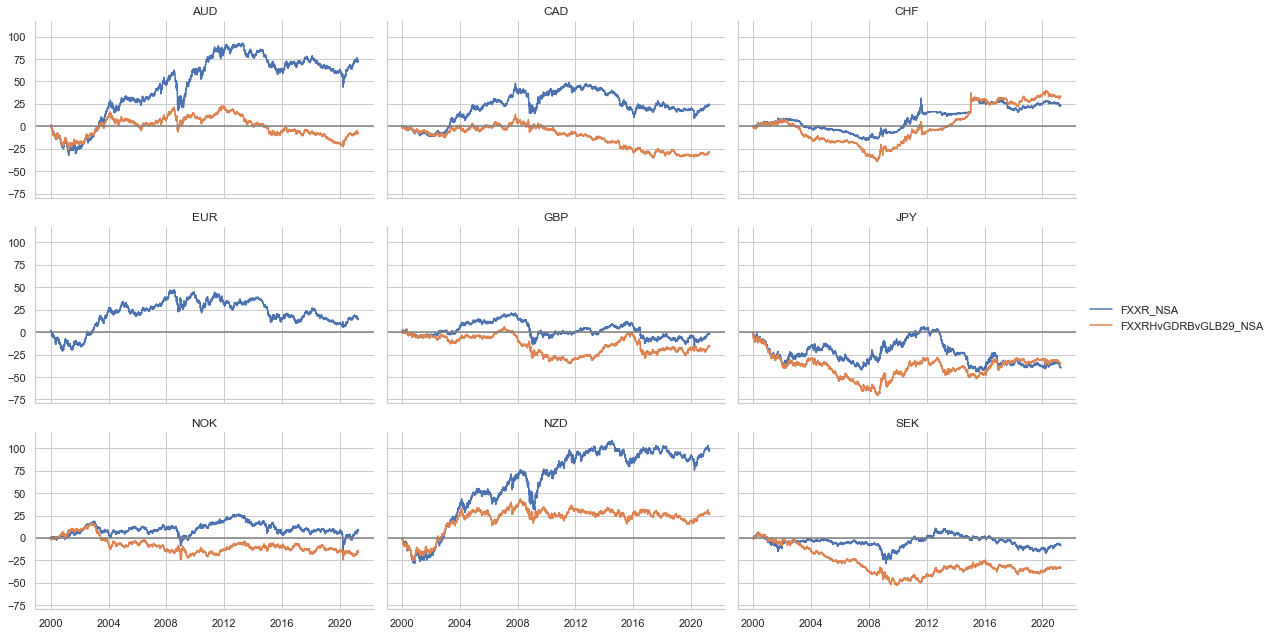

In [44]:
timeline_grid(dfd, xcats=['FXXR_NSA', 'FXXRHvGDRBvGLB29_NSA'], cids=cids_dm, same_y=True, cumsum=True)

Missing cross sections:  {'ARS', 'HKD'}


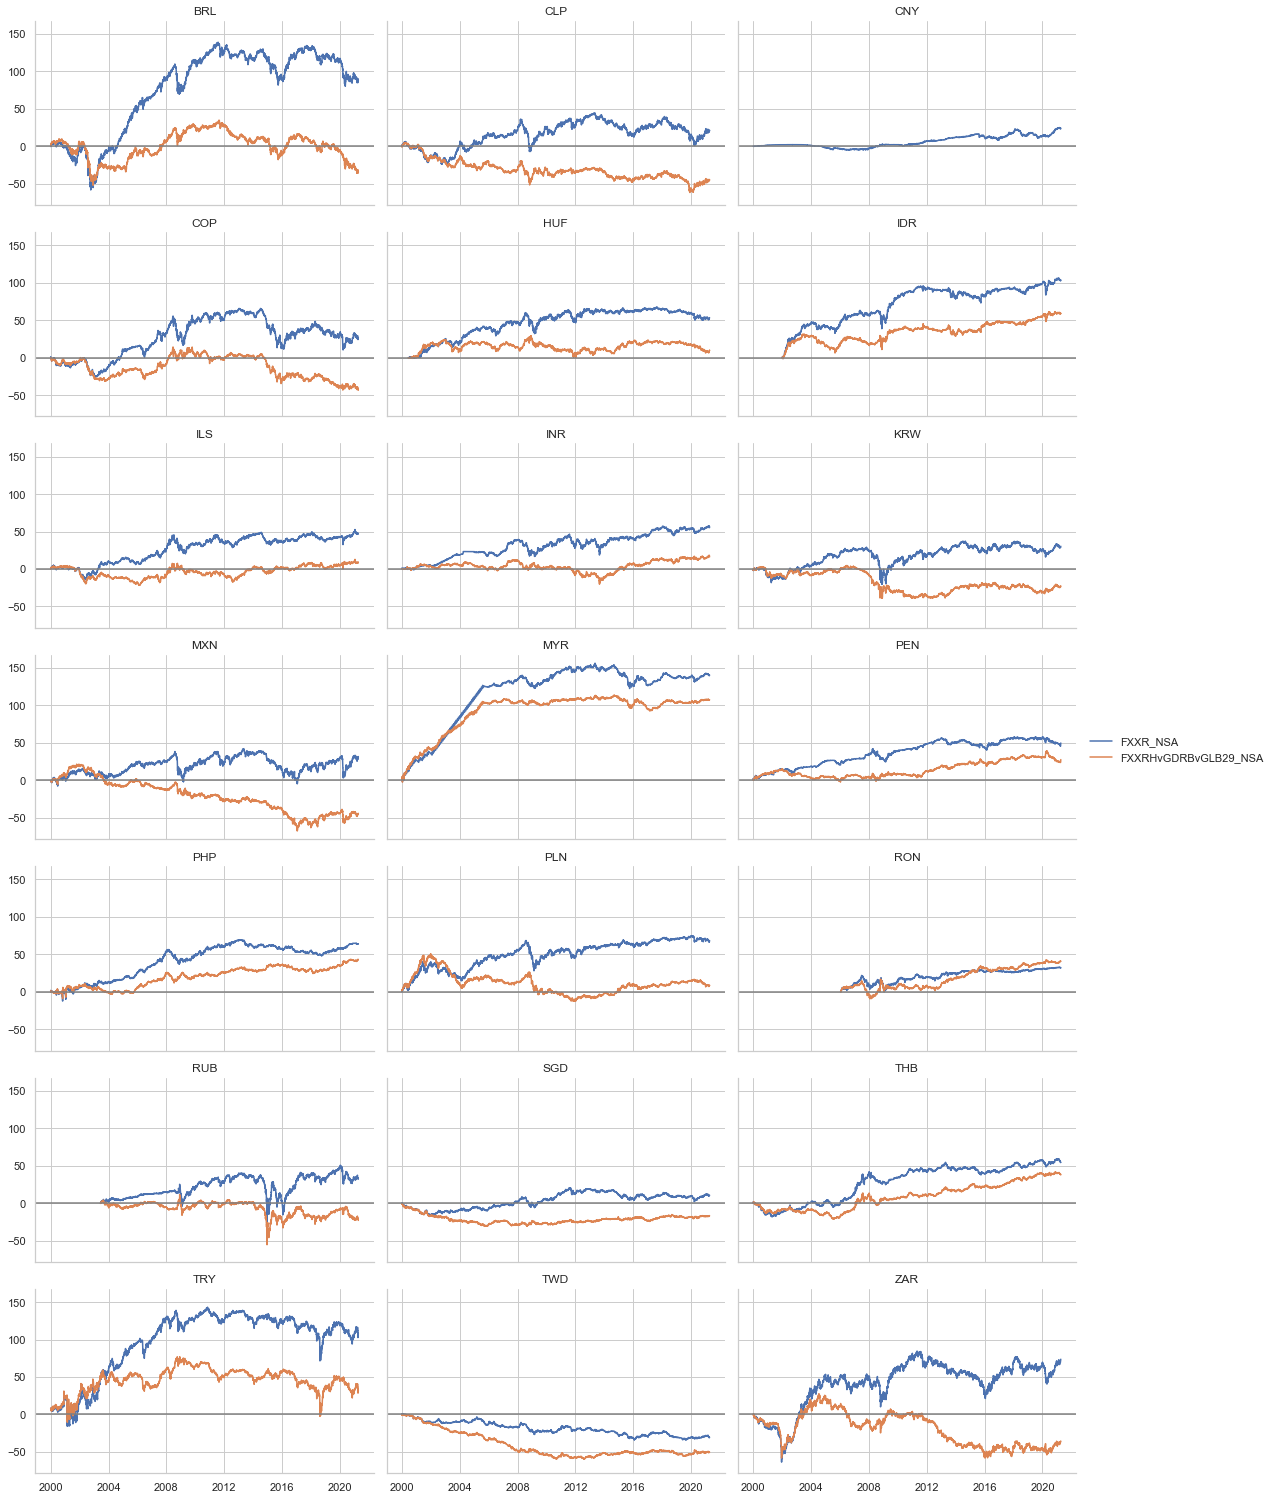

In [45]:
timeline_grid(dfd, xcats=['FXXR_NSA', 'FXXRHvGDRBvGLB29_NSA'], cids=cids_em, same_y=True, cumsum=True)

### Carry

#### Simple nominal and real carry

Missing cross sections:  set()


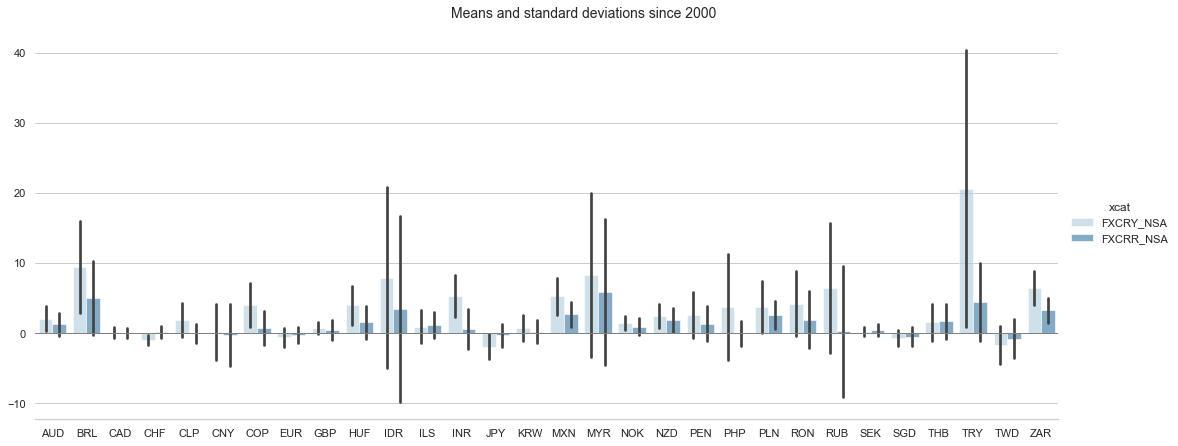

In [46]:
bars_sds(dfd, xcats=['FXCRY_NSA', 'FXCRR_NSA'], cids=cids_exp)

Missing cross sections:  {'FRF', 'DEM', 'ITL', 'ESP', 'USD', 'NLG'}


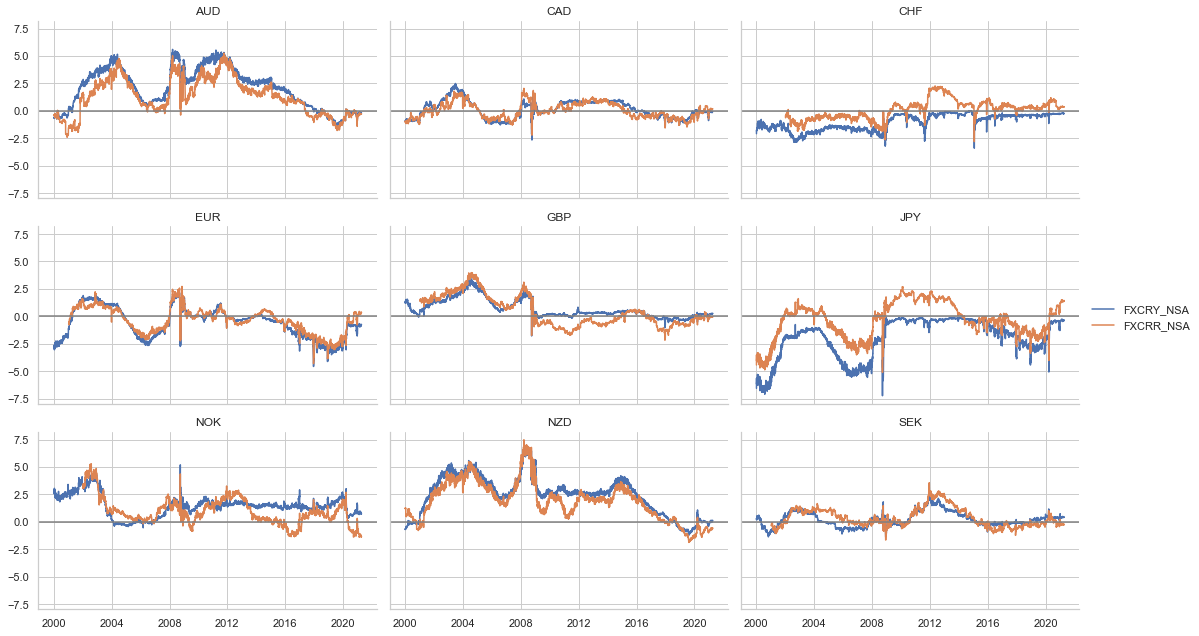

In [51]:
timeline_grid(dfd, xcats=['FXCRY_NSA', 'FXCRR_NSA'], cids=cids_dm, same_y=True)

Missing cross sections:  {'ARS', 'HKD'}


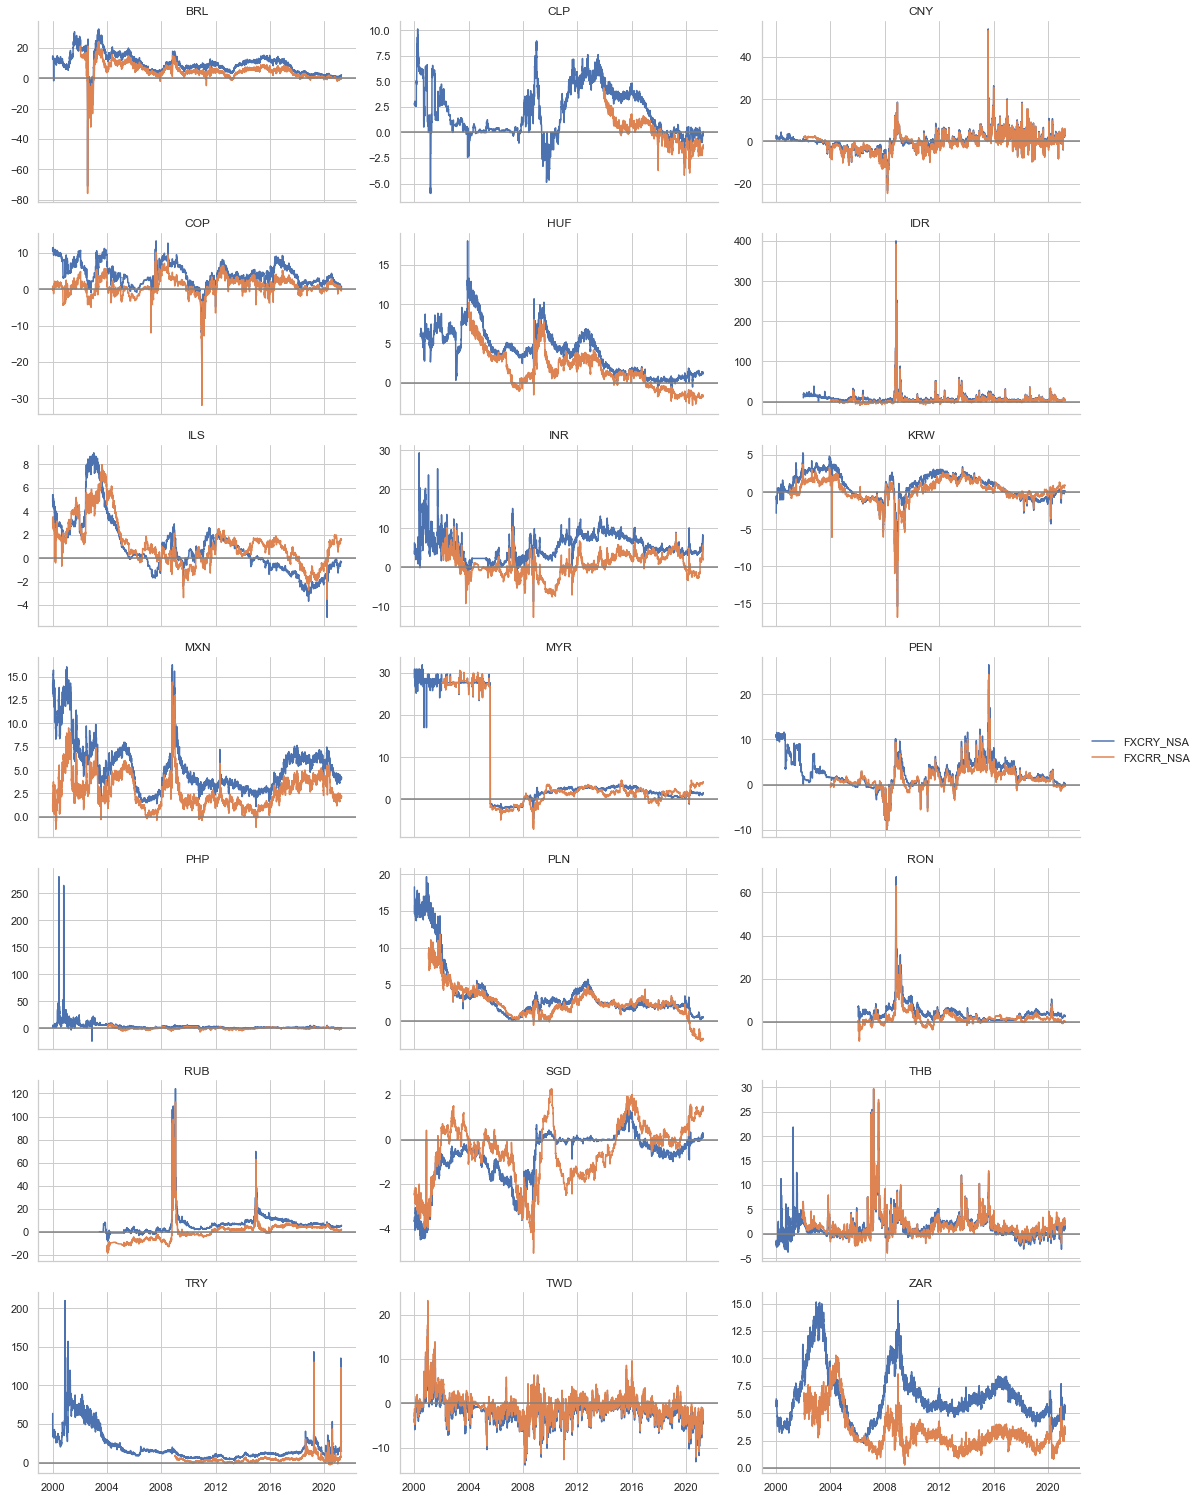

In [53]:
timeline_grid(dfd, xcats=['FXCRY_NSA', 'FXCRR_NSA'], cids=cids_em, same_y=False)

#### Vol-targeted nominal and real carries

Missing cross sections:  set()


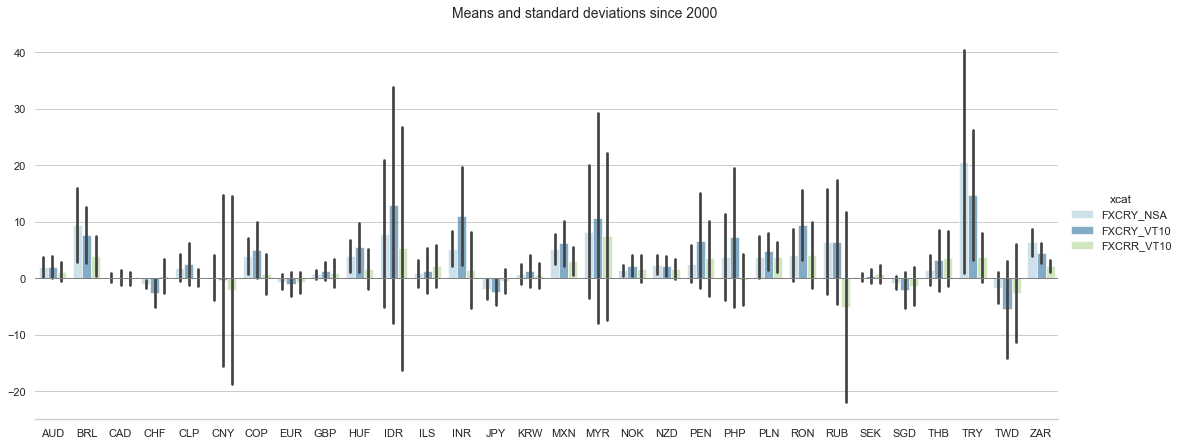

In [50]:
bars_sds(dfd, xcats=['FXCRY_NSA', 'FXCRY_VT10', 'FXCRR_VT10'], cids=cids_exp)

Missing cross sections:  {'FRF', 'DEM', 'ITL', 'ESP', 'USD', 'NLG'}


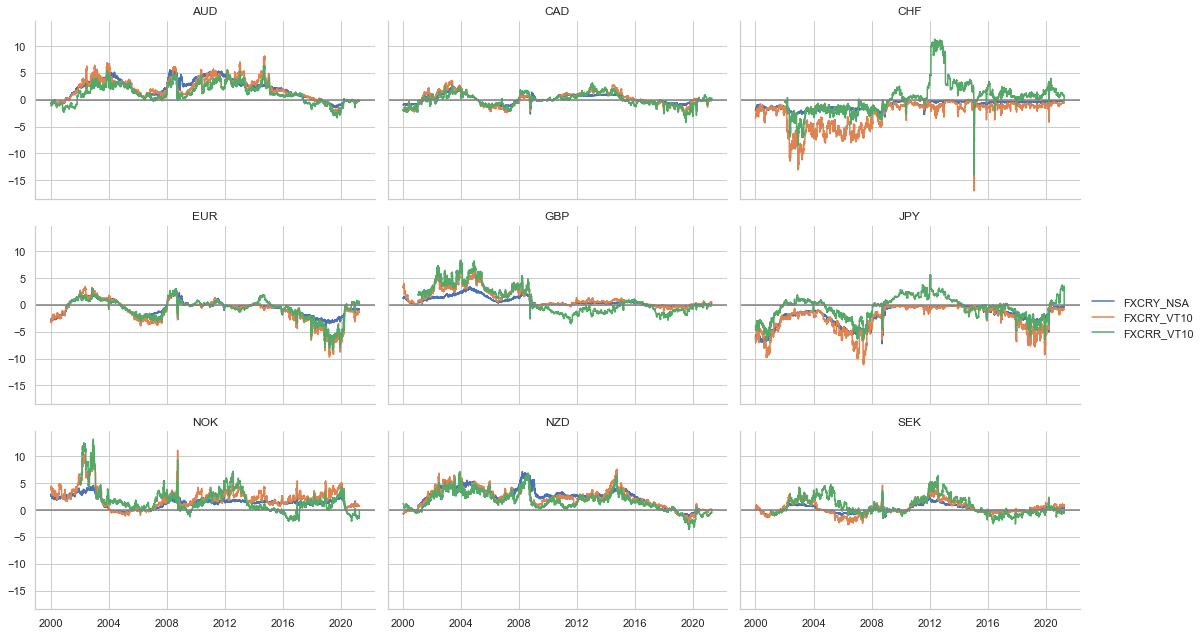

In [55]:
timeline_grid(dfd, xcats=['FXCRY_NSA', 'FXCRY_VT10', 'FXCRR_VT10'], cids=cids_dm, same_y=True)

Missing cross sections:  {'ARS', 'HKD'}


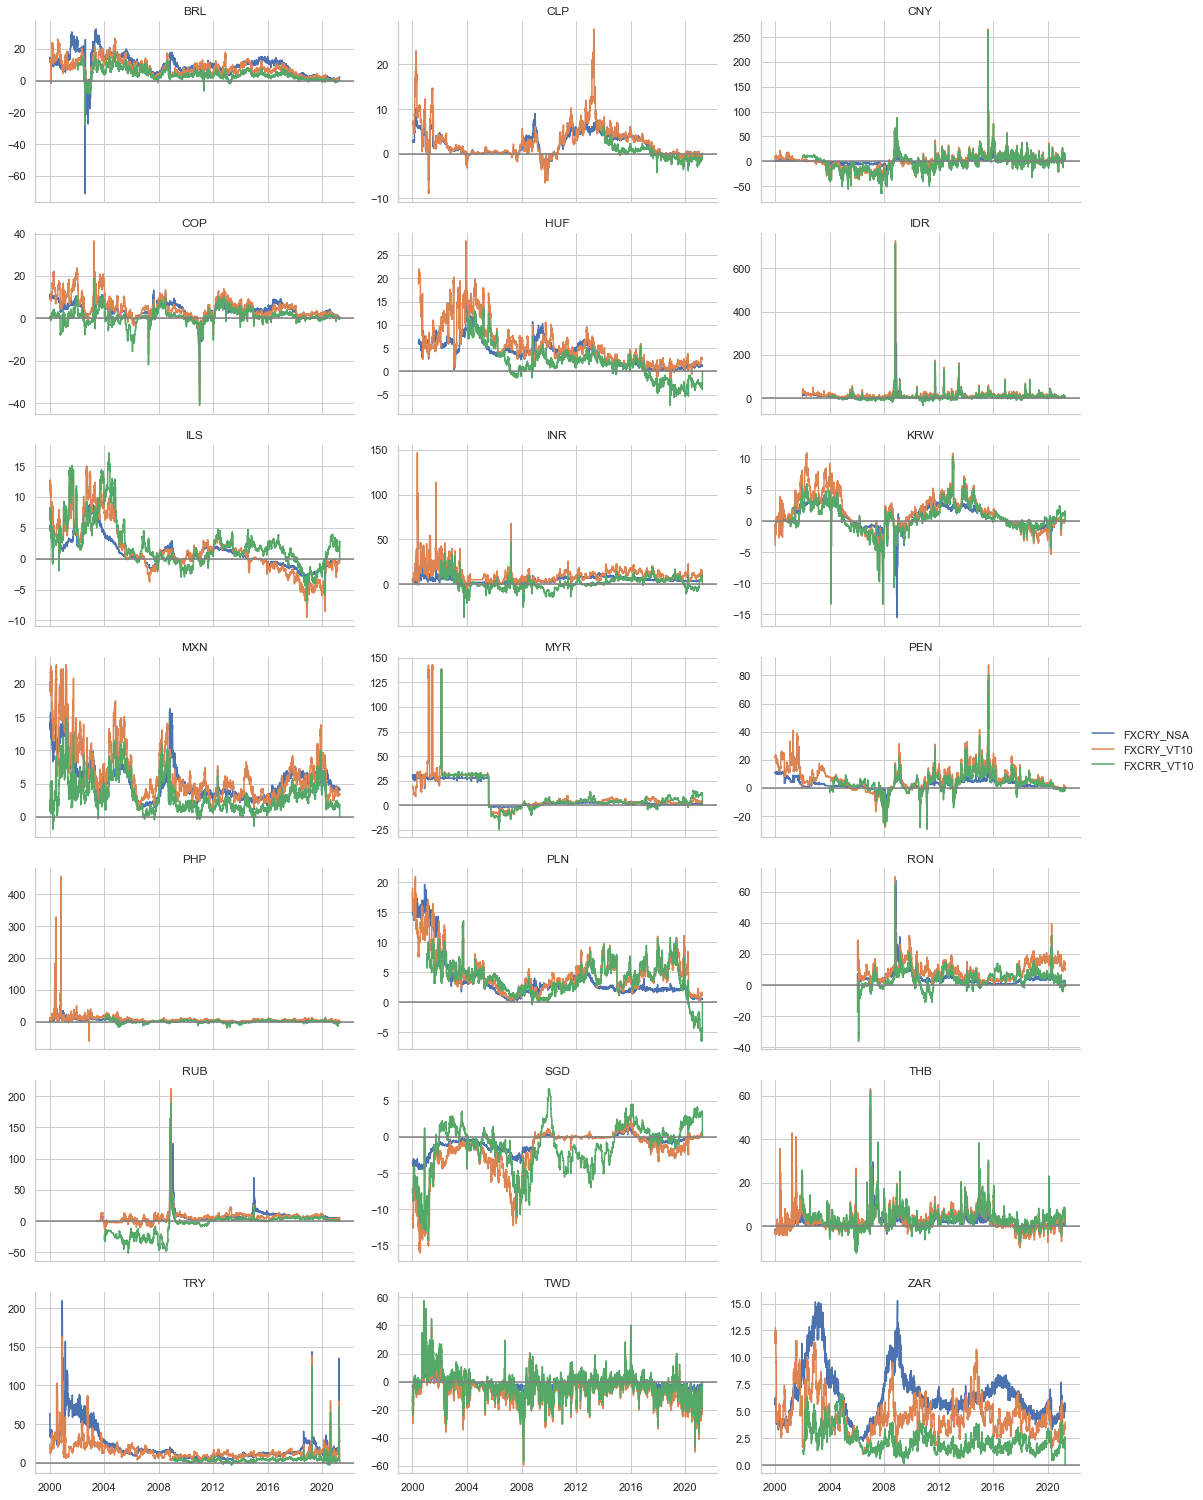

In [56]:
timeline_grid(dfd, xcats=['FXCRY_NSA', 'FXCRY_VT10', 'FXCRR_VT10'], cids=cids_em, same_y=False)

#### Relative vol-targeted carry

Missing cross sections:  set()


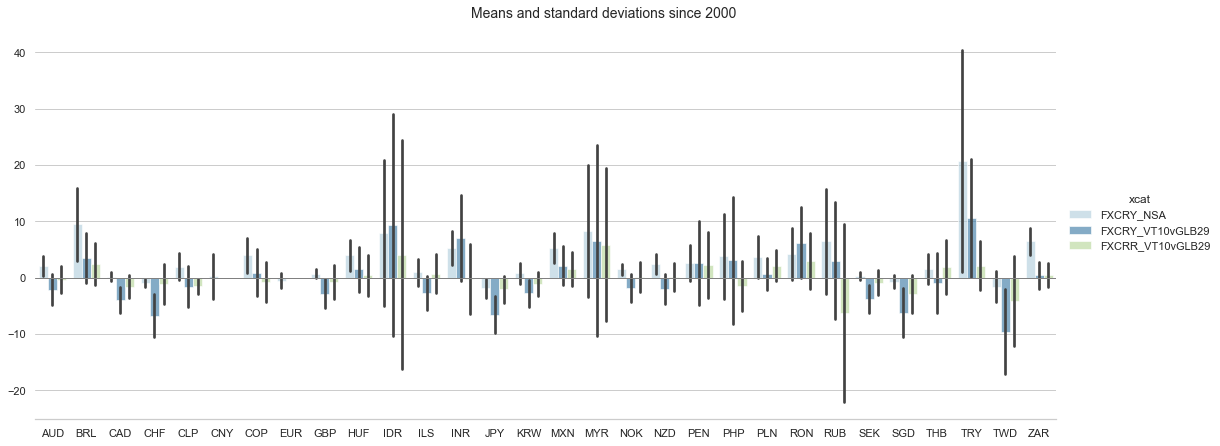

In [57]:
bars_sds(dfd, xcats=['FXCRY_NSA', 'FXCRY_VT10vGLB29', 'FXCRR_VT10vGLB29'], cids=cids_exp)

Missing cross sections:  {'FRF', 'DEM', 'ITL', 'ESP', 'USD', 'NLG'}


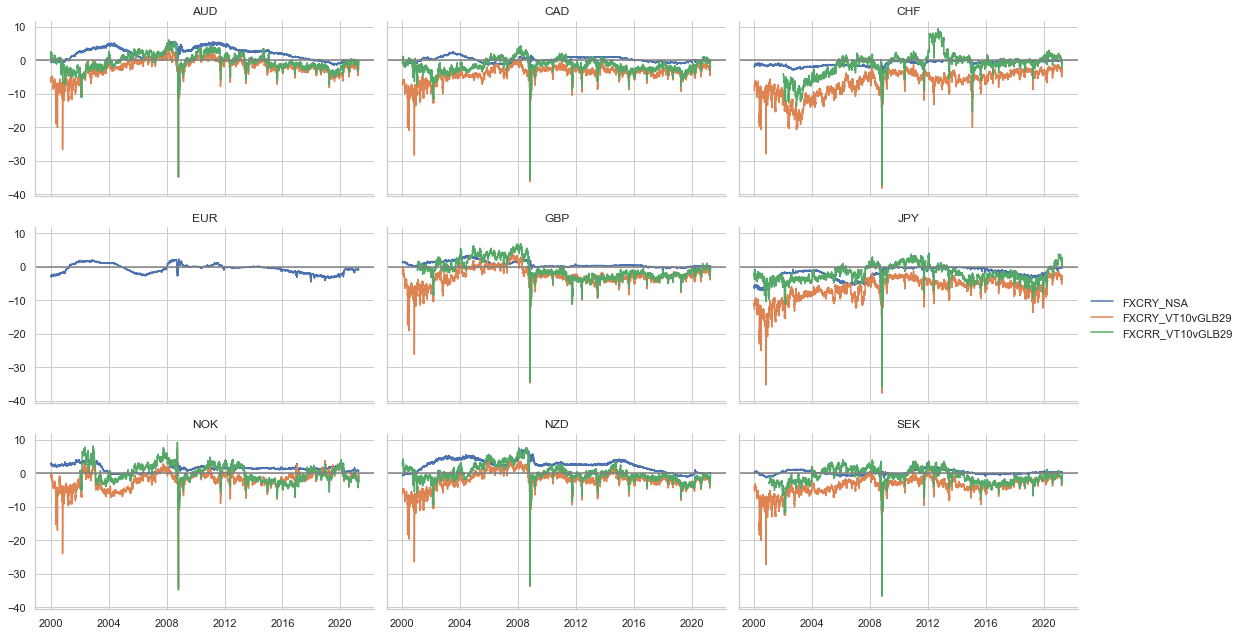

In [58]:
timeline_grid(dfd, xcats=['FXCRY_NSA', 'FXCRY_VT10vGLB29', 'FXCRR_VT10vGLB29'], cids=cids_dm, same_y=True)

Missing cross sections:  {'ARS', 'HKD'}


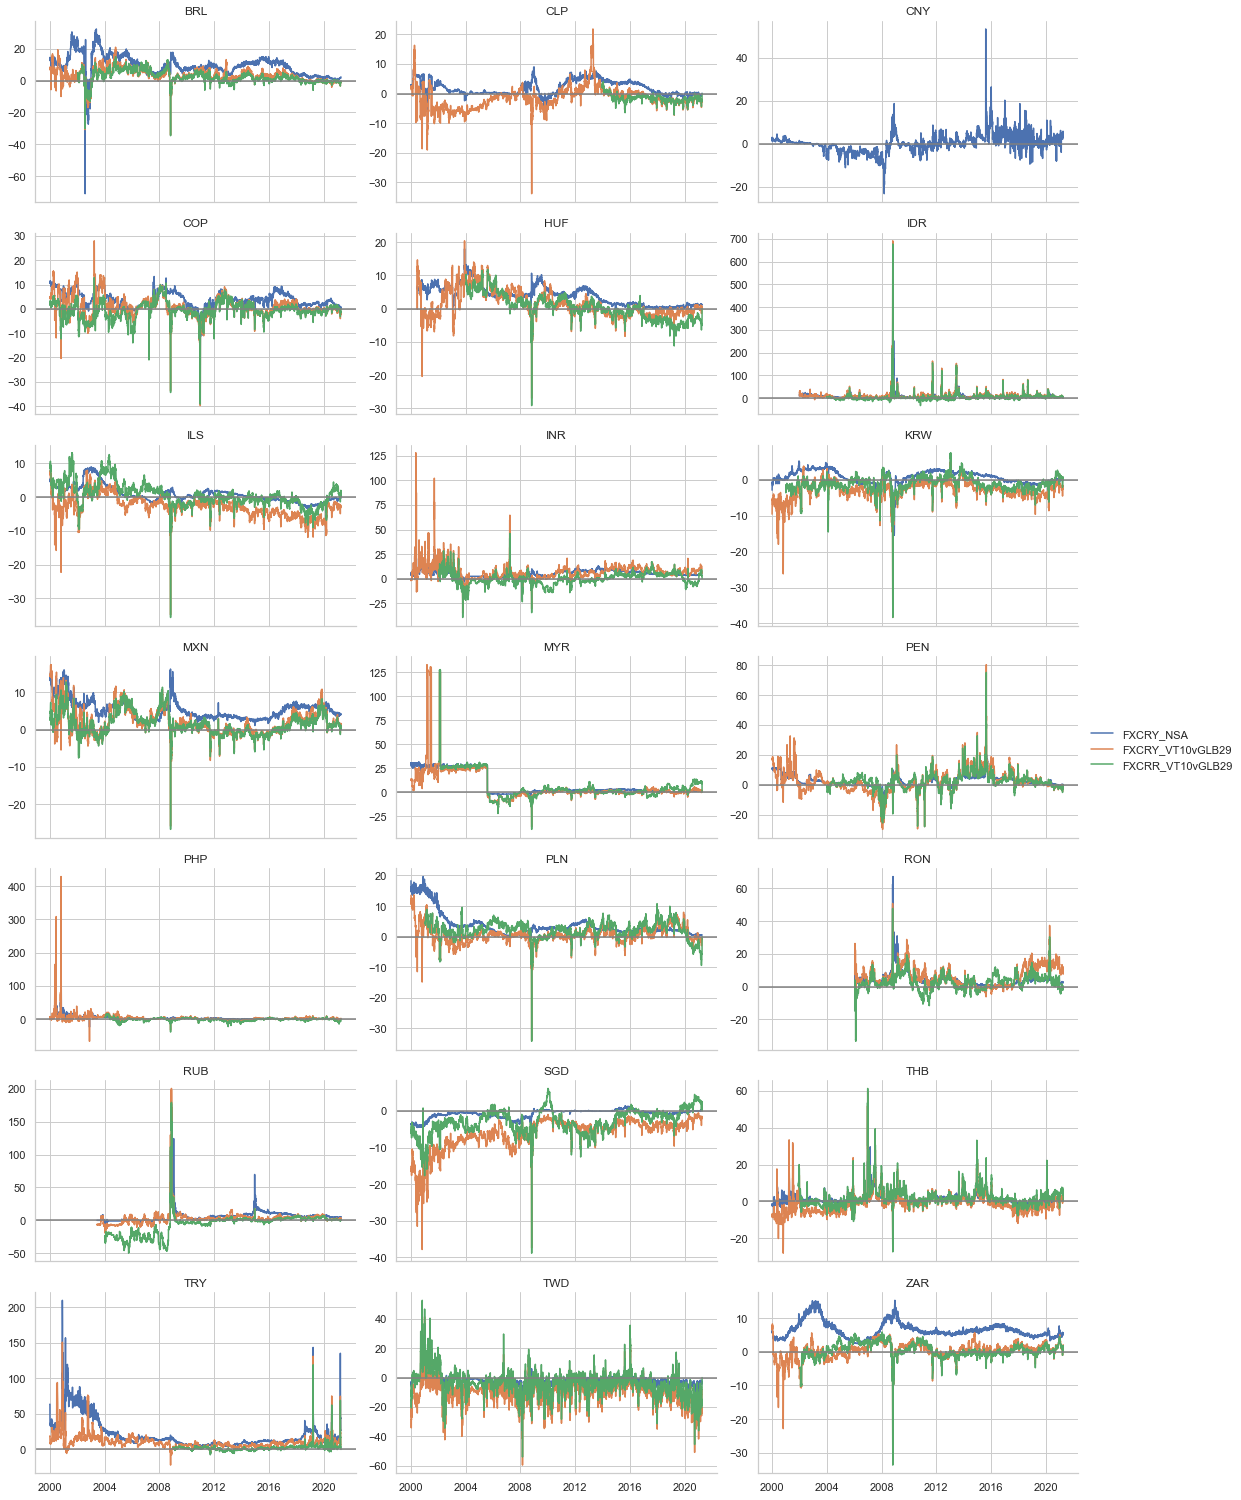

In [59]:
timeline_grid(dfd, xcats=['FXCRY_NSA', 'FXCRY_VT10vGLB29', 'FXCRR_VT10vGLB29'], cids=cids_em, same_y=False)

#### Hedged carry

Missing cross sections:  set()


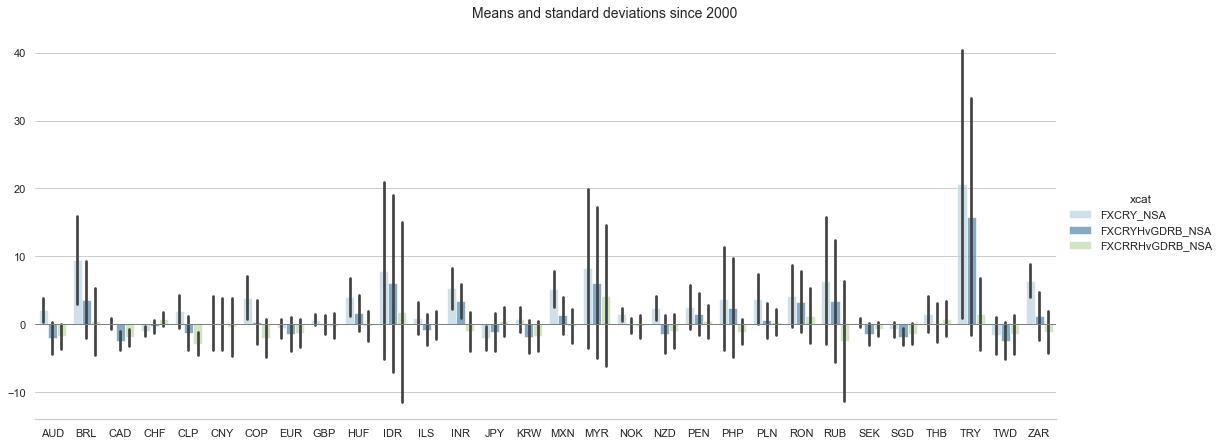

In [60]:
bars_sds(dfd, xcats=['FXCRY_NSA', 'FXCRYHvGDRB_NSA', 'FXCRRHvGDRB_NSA'], cids=cids_exp)

Missing cross sections:  {'FRF', 'DEM', 'ITL', 'ESP', 'USD', 'NLG'}


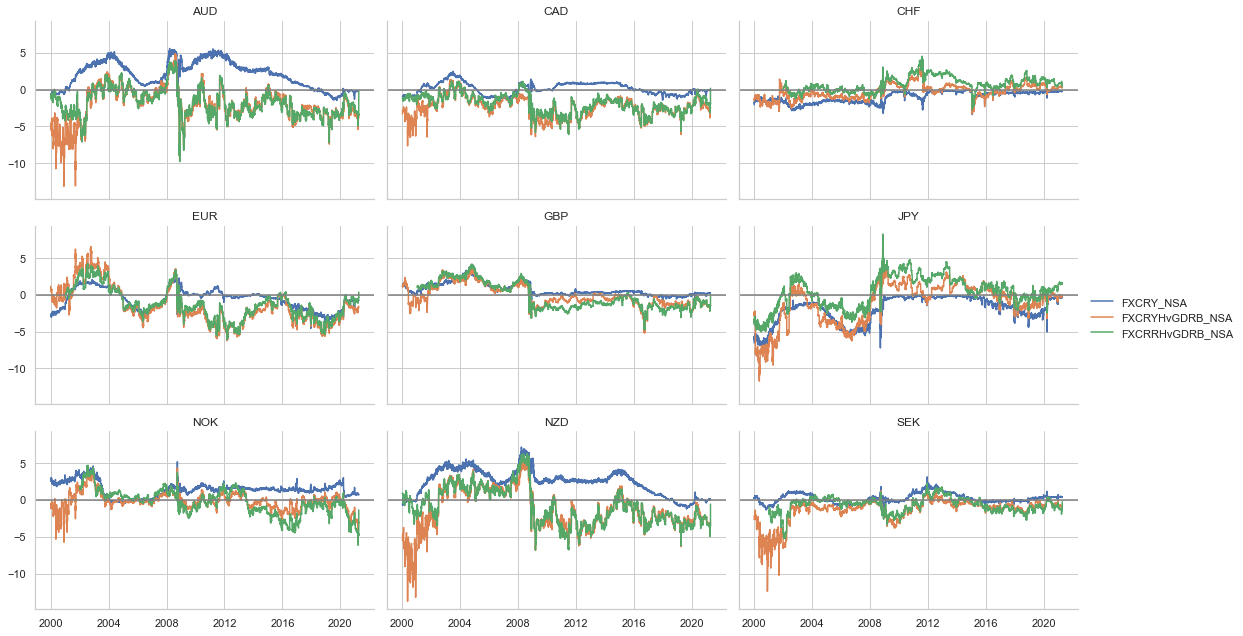

In [62]:
timeline_grid(dfd, xcats=['FXCRY_NSA', 'FXCRYHvGDRB_NSA', 'FXCRRHvGDRB_NSA'], cids=cids_dm, same_y=True)

Missing cross sections:  {'ARS', 'HKD'}


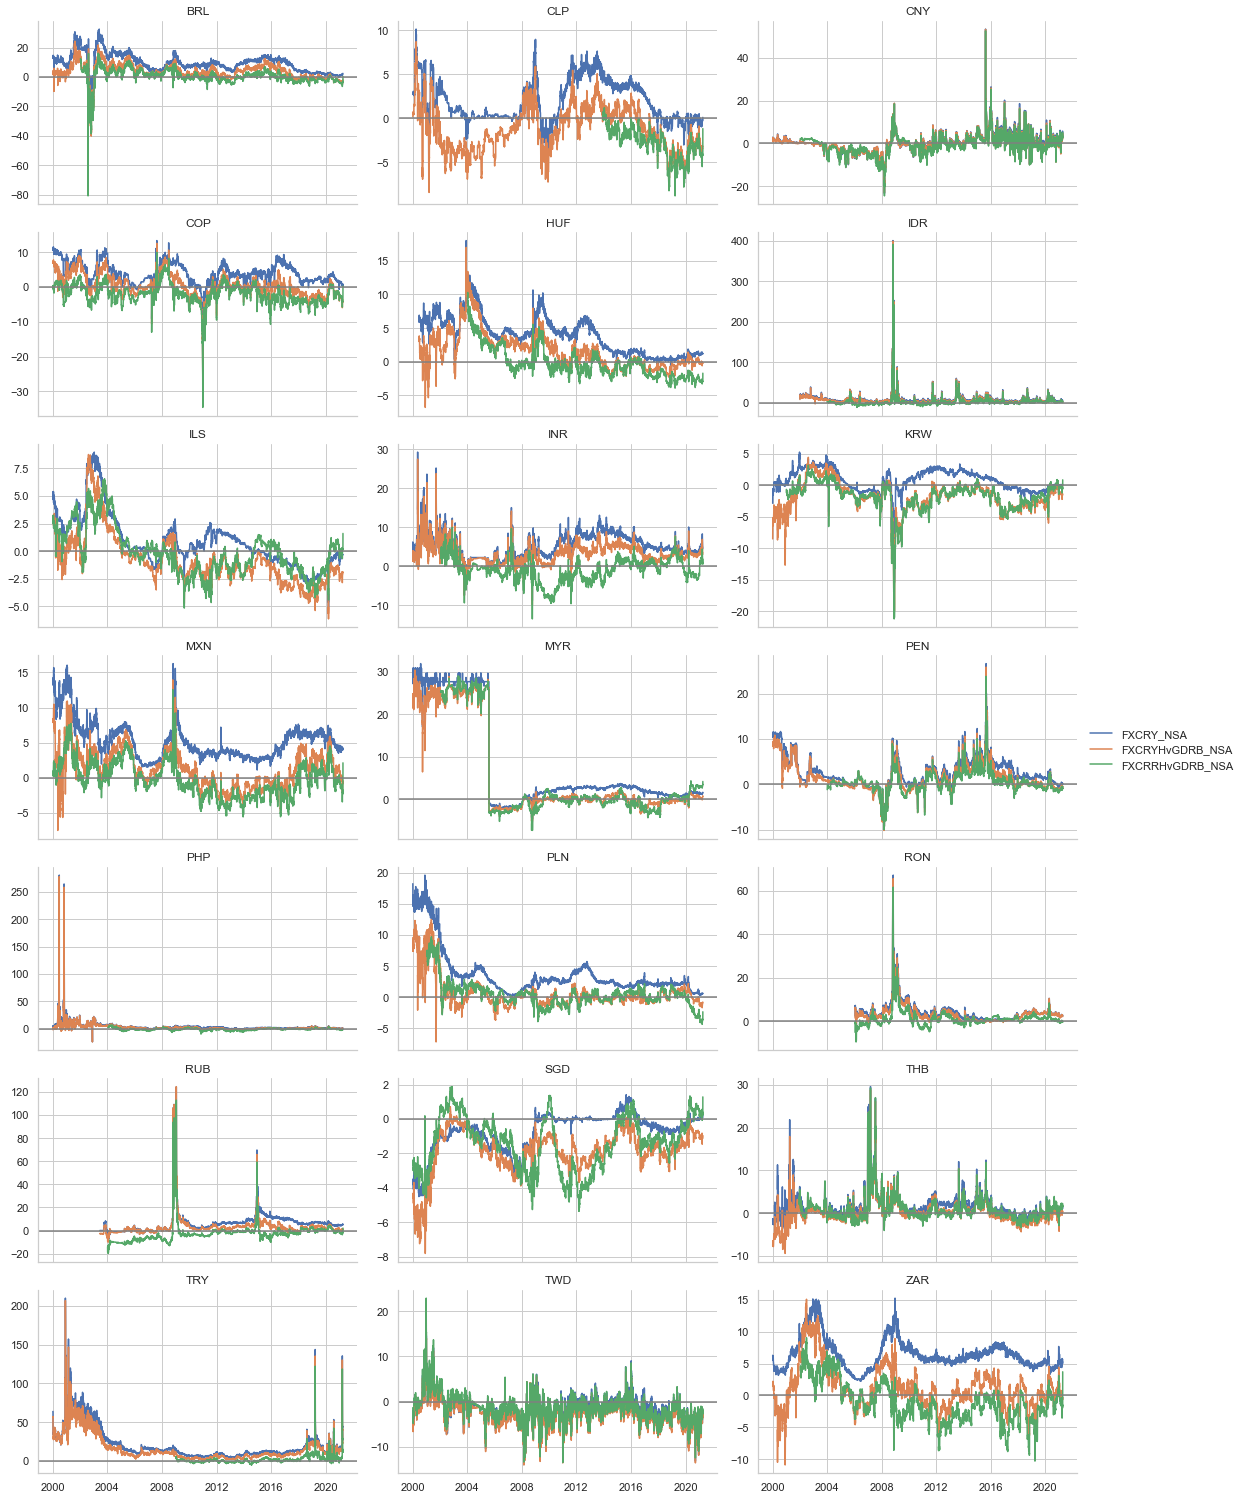

In [63]:
timeline_grid(dfd, xcats=['FXCRY_NSA', 'FXCRYHvGDRB_NSA', 'FXCRRHvGDRB_NSA'], cids=cids_em, same_y=False)

#### Relative hedged carry

Missing cross sections:  set()


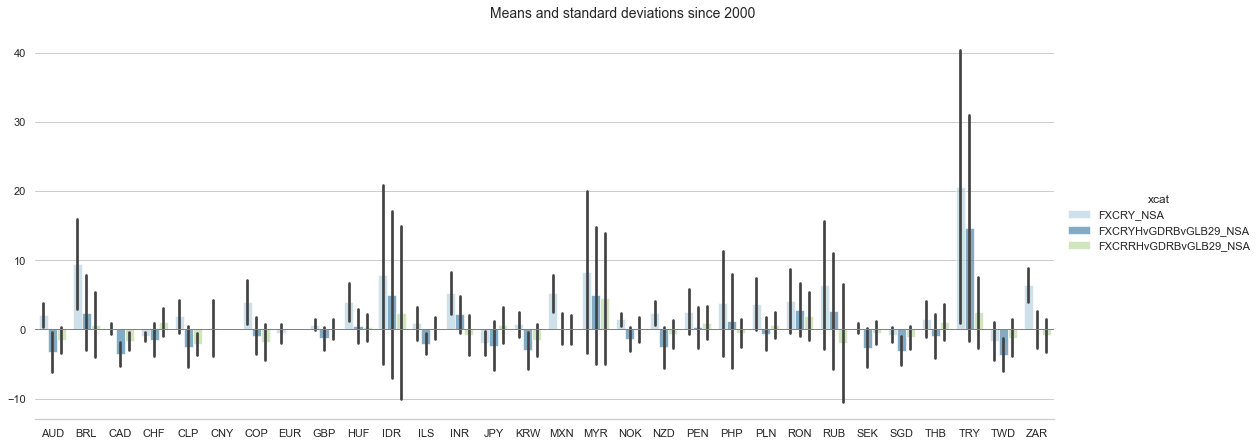

In [64]:
bars_sds(dfd, xcats=['FXCRY_NSA', 'FXCRYHvGDRBvGLB29_NSA', 'FXCRRHvGDRBvGLB29_NSA'], cids=cids_exp)

Missing cross sections:  {'FRF', 'DEM', 'ITL', 'ESP', 'USD', 'NLG'}


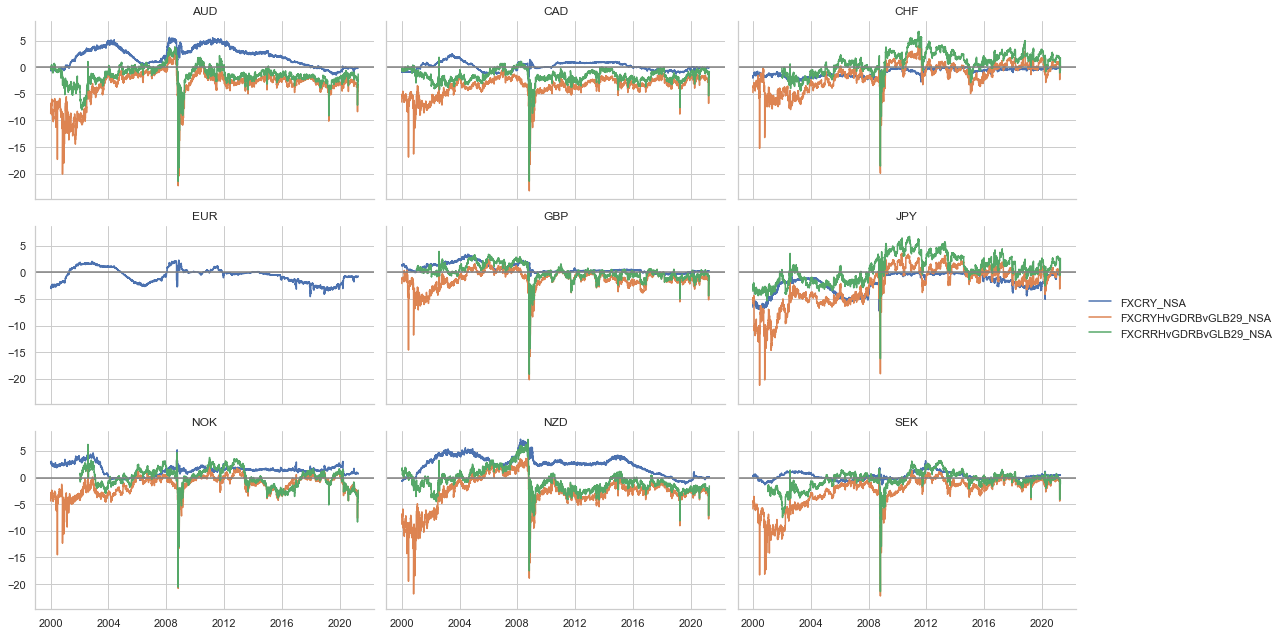

In [65]:
timeline_grid(dfd, xcats=['FXCRY_NSA', 'FXCRYHvGDRBvGLB29_NSA', 'FXCRRHvGDRBvGLB29_NSA'], cids=cids_dm, same_y=True)

Missing cross sections:  {'ARS', 'HKD'}


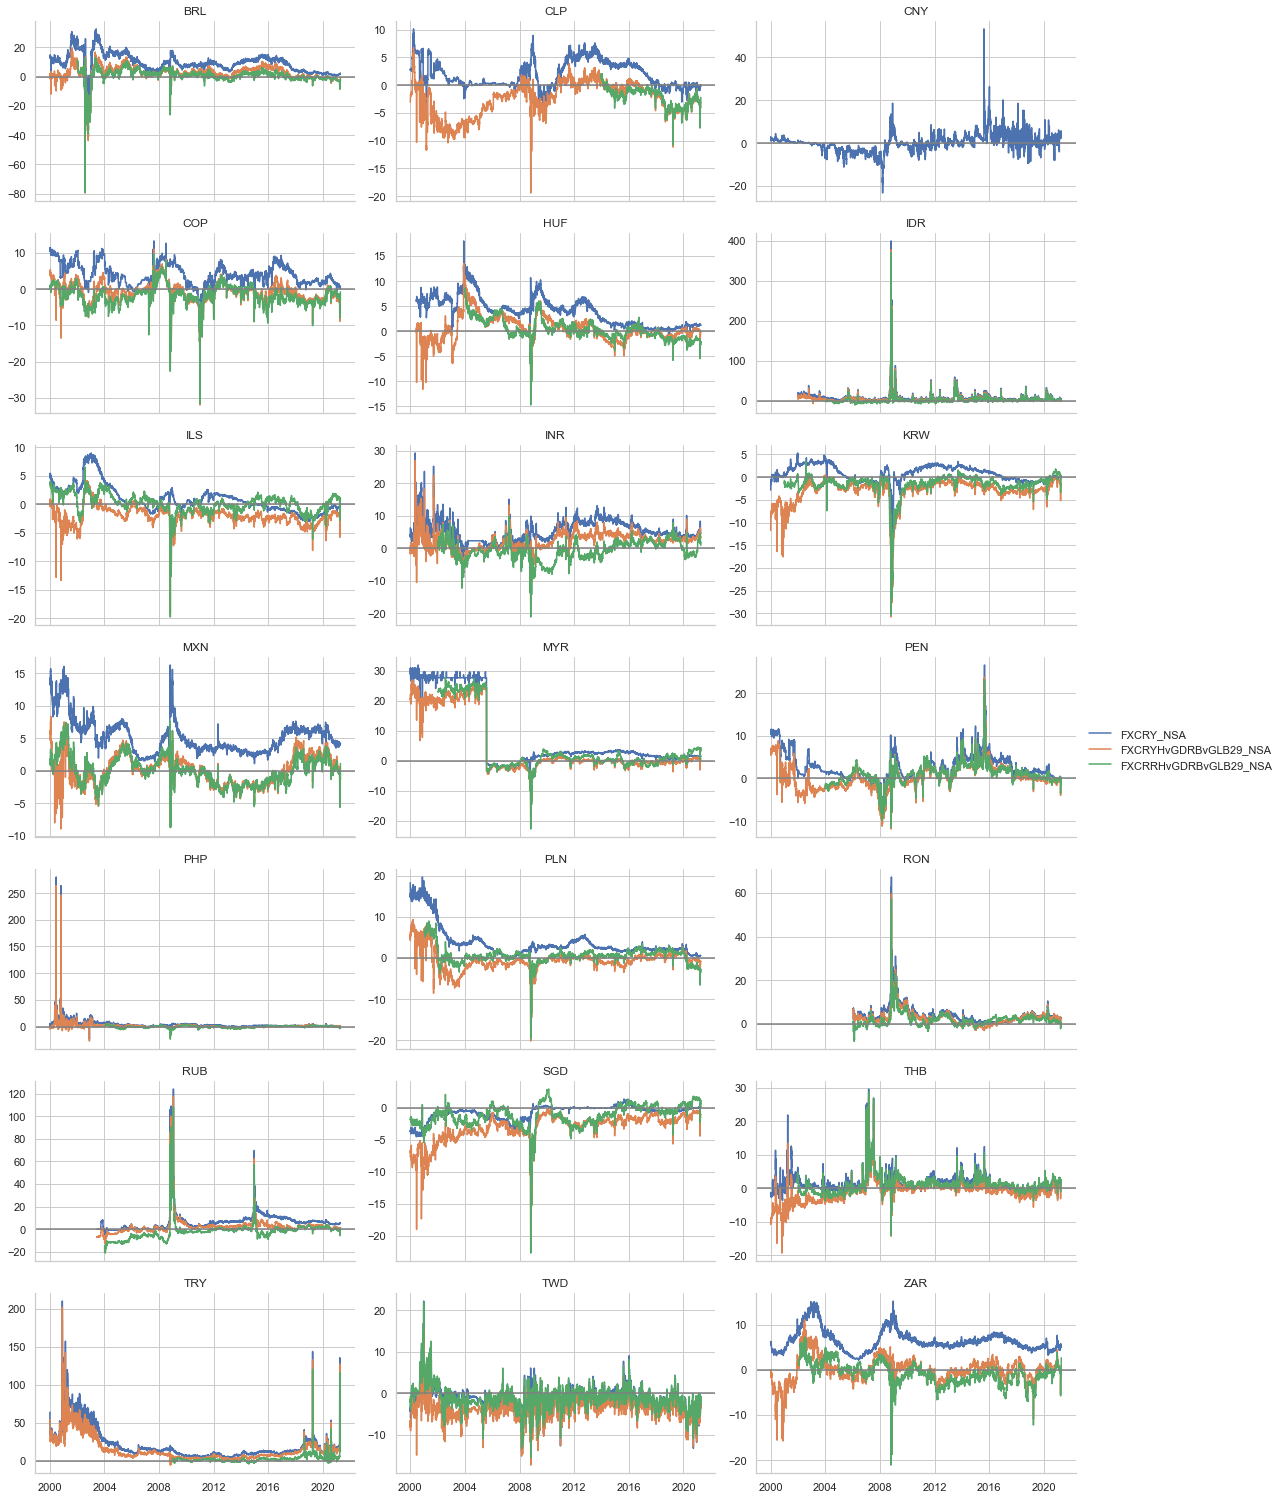

In [66]:
timeline_grid(dfd, xcats=['FXCRY_NSA', 'FXCRYHvGDRBvGLB29_NSA', 'FXCRRHvGDRBvGLB29_NSA'], cids=cids_em, same_y=False)